<a href="https://colab.research.google.com/github/202203019/Daily_Euro_Exchange_Rate/blob/main/Euro_To_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Data Upload`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the data (no need for parse_dates initially)
df = pd.read_csv('https://raw.githubusercontent.com/202203019/Lab-1/refs/heads/main/euro-daily-hist_1999_2022.csv')

# First check the exact column name
print("Original columns:", df.columns.tolist())

# Then rename using the proper escape
df = df.rename(columns={'Period\\Unit:': 'Date'})

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Verify
print("\nAfter renaming:")
print(df.head())
# Basic info
print("Data shape:", df.shape)
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Missing values:\n", df.isnull().sum())

Original columns: ['Period\\Unit:', '[Australian dollar ]', '[Bulgarian lev ]', '[Brazilian real ]', '[Canadian dollar ]', '[Swiss franc ]', '[Chinese yuan renminbi ]', '[Cypriot pound ]', '[Czech koruna ]', '[Danish krone ]', '[Estonian kroon ]', '[UK pound sterling ]', '[Greek drachma ]', '[Hong Kong dollar ]', '[Croatian kuna ]', '[Hungarian forint ]', '[Indonesian rupiah ]', '[Israeli shekel ]', '[Indian rupee ]', '[Iceland krona ]', '[Japanese yen ]', '[Korean won ]', '[Lithuanian litas ]', '[Latvian lats ]', '[Maltese lira ]', '[Mexican peso ]', '[Malaysian ringgit ]', '[Norwegian krone ]', '[New Zealand dollar ]', '[Philippine peso ]', '[Polish zloty ]', '[Romanian leu ]', '[Russian rouble ]', '[Swedish krona ]', '[Singapore dollar ]', '[Slovenian tolar ]', '[Slovak koruna ]', '[Thai baht ]', '[Turkish lira ]', '[US dollar ]', '[South African rand ]']

After renaming:
        Date [Australian dollar ] [Bulgarian lev ] [Brazilian real ]  \
0 2024-09-27                1.618       

# `Trending and Seasonality`

Raw data plot

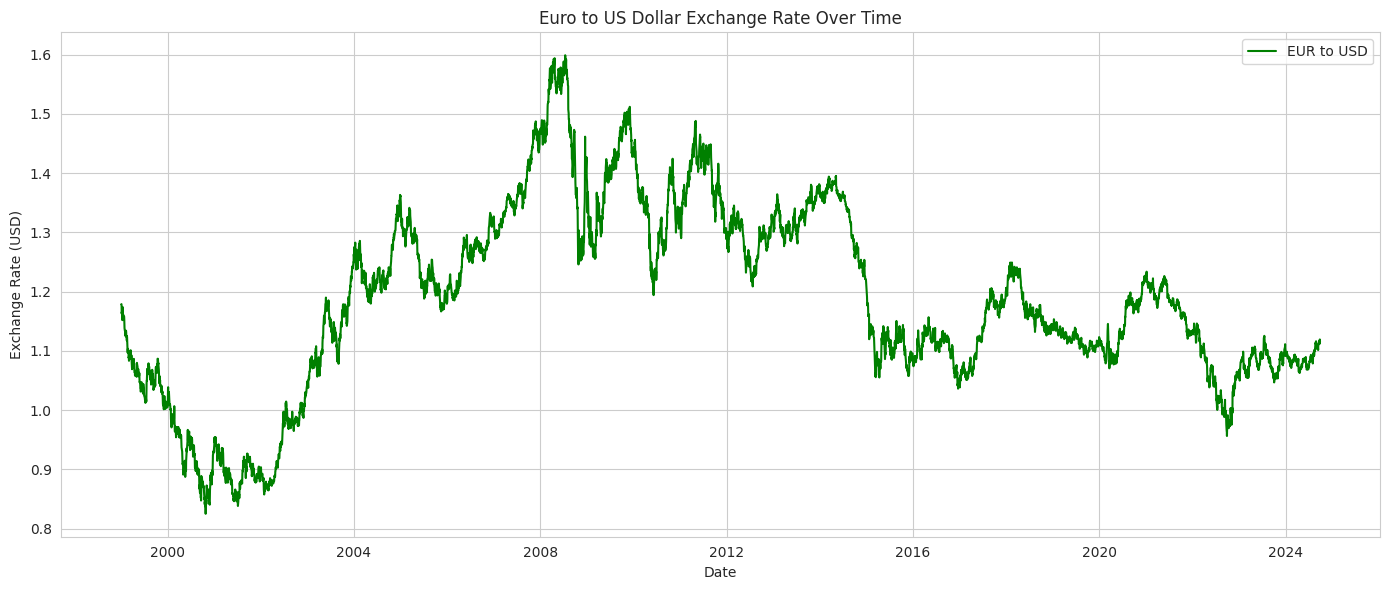

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/202203019/Lab-1/refs/heads/main/euro-daily-hist_1999_2022.csv')

df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

df_usd = df[['Date', '[US dollar ]']].copy()

df_usd['Date'] = pd.to_datetime(df_usd['Date'], errors='coerce')

df_usd['[US dollar ]'] = pd.to_numeric(df_usd['[US dollar ]'], errors='coerce')

df_usd.dropna(inplace=True)

df_usd.sort_values('Date', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df_usd['Date'], df_usd['[US dollar ]'], color='green', label='EUR to USD')
plt.title('Euro to US Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Rolling mean and standard deviation

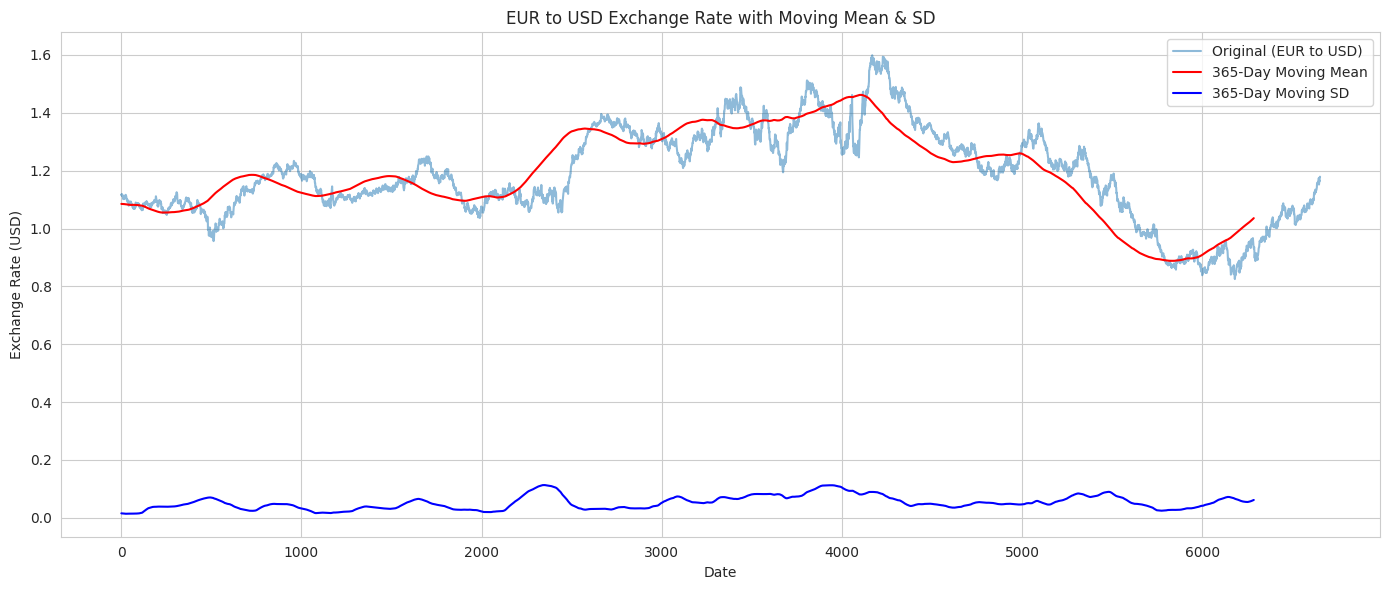

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

window = 365

df_usd['Moving_Mean'] = df_usd['[US dollar ]'].rolling(window=window).mean()
df_usd['Moving_SD'] = df_usd['[US dollar ]'].rolling(window=window).std()

plt.figure(figsize=(14, 6))
plt.plot(df_usd['[US dollar ]'], label='Original (EUR to USD)', alpha=0.5)
plt.plot(df_usd['Moving_Mean'], label=f'{window}-Day Moving Mean', color='red')
plt.plot(df_usd['Moving_SD'], label=f'{window}-Day Moving SD', color='blue')
plt.title('EUR to USD Exchange Rate with Moving Mean & SD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plot of euro exchange rate over 8 year (for seasonality check)

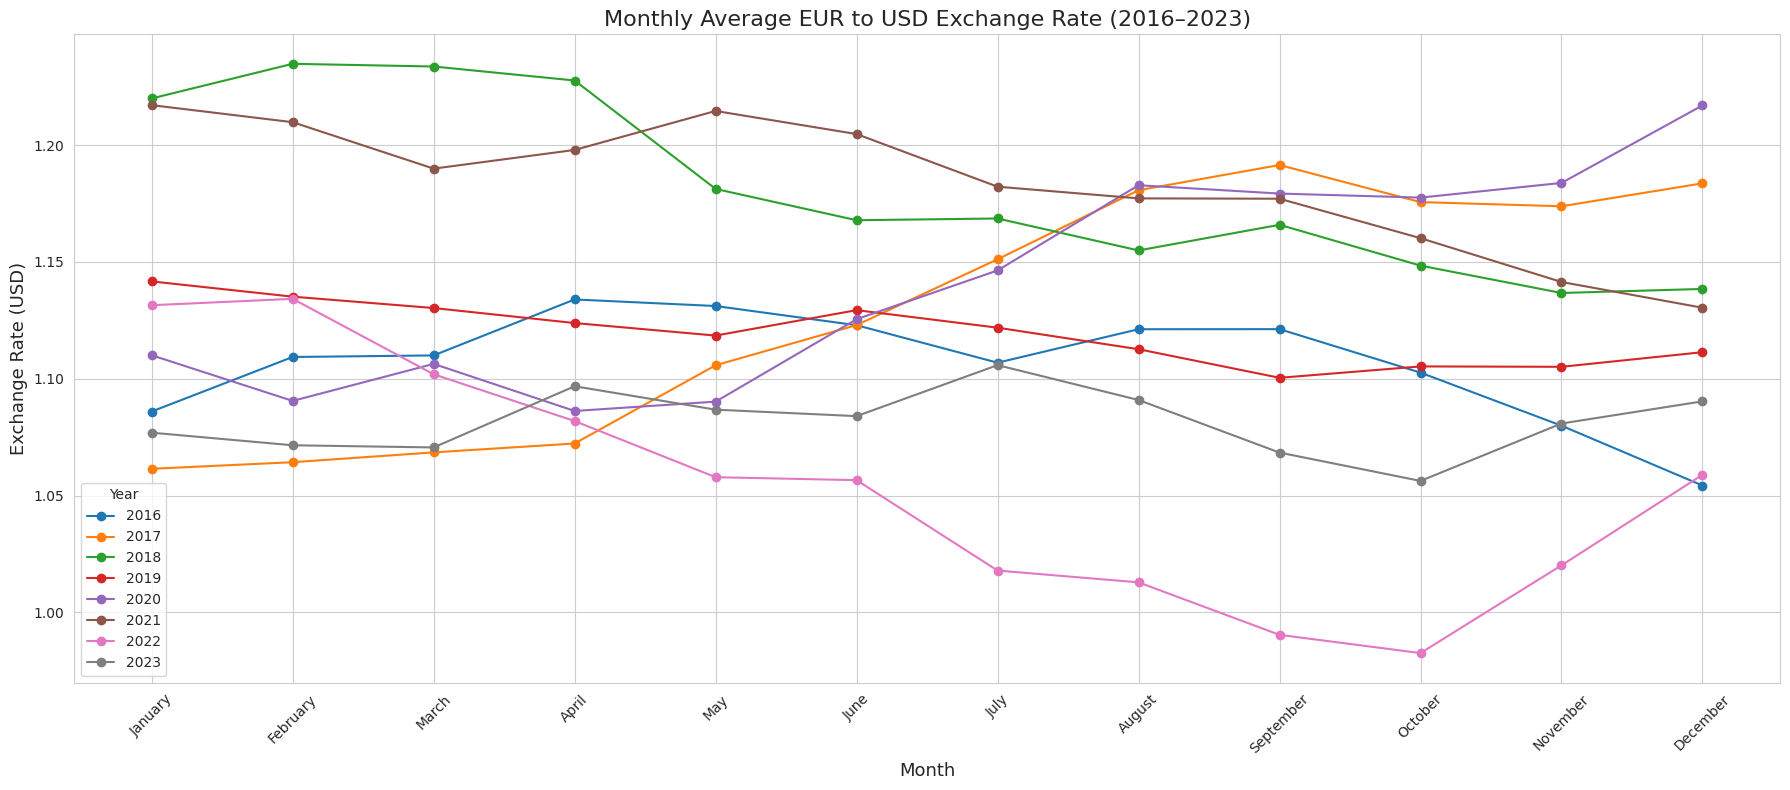

<Figure size 1800x1000 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/202203019/Lab-1/refs/heads/main/euro-daily-hist_1999_2022.csv')

df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

df_usd = df[['Date', '[US dollar ]']].copy()

df_usd['Date'] = pd.to_datetime(df_usd['Date'], errors='coerce')

df_usd['[US dollar ]'] = pd.to_numeric(df_usd['[US dollar ]'], errors='coerce')

df_usd.dropna(inplace=True)

df_usd['Year'] = df_usd['Date'].dt.year
df_usd['Month'] = df_usd['Date'].dt.month
df_usd['Month_Name'] = df_usd['Date'].dt.month_name()

pre_covid = df_usd[(df_usd['Year'] >= 2016) & (df_usd['Year'] <= 2019)]
post_covid = df_usd[(df_usd['Year'] >= 2020) & (df_usd['Year'] <= 2023)]

pre_monthly = pre_covid.groupby(['Year', 'Month', 'Month_Name'])['[US dollar ]'].mean().reset_index()
post_monthly = post_covid.groupby(['Year', 'Month', 'Month_Name'])['[US dollar ]'].mean().reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

combined_monthly = pd.concat([pre_monthly, post_monthly])

combined_monthly['Month_Name'] = pd.Categorical(combined_monthly['Month_Name'], categories=month_order, ordered=True)

plt.figure(figsize=(18, 8))
sns.set_style("whitegrid")
palette = sns.color_palette("tab10", 8)

for i, year in enumerate(range(2016, 2024)):
    year_data = combined_monthly[combined_monthly['Year'] == year]
    complete_months = pd.DataFrame({'Month_Name': month_order})
    year_data_complete = complete_months.merge(year_data, on='Month_Name', how='left')
    plt.plot(year_data_complete['Month_Name'], year_data_complete['[US dollar ]'],
             marker='o', label=str(year), color=palette[i % len(palette)])

plt.title('Monthly Average EUR to USD Exchange Rate (2016‚Äì2023)', fontsize=16)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Exchange Rate (USD)', fontsize=13)
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 10))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", 8)


# Pre-COVID subplot
# plt.subplot(2, 1, 1)
# for i, year in enumerate([2016, 2017, 2018, 2019]):
#     year_data = pre_monthly[pre_monthly['Year'] == year]
#     # Ensure all months are present (fill missing with NaN)
#     complete_months = pd.DataFrame({'Month_Name': month_order})
#     year_data_complete = complete_months.merge(year_data, on='Month_Name', how='left')
#     plt.plot(year_data_complete['Month_Name'], year_data_complete['[US dollar ]'],
#              marker='o', color=palette[i], label=str(year))

# plt.title('Pre-COVID Monthly Average USD/INR Exchange Rate (2016-2019)')
# plt.xlabel('Month')
# plt.ylabel('Exchange Rate (INR)')
# plt.legend(title='Year')
# plt.xticks(rotation=45)

# Post-COVID subplot
# plt.subplot(2, 1, 1)
# for i, year in enumerate([2016, 2017, 2018, 2019,2020, 2021, 2022, 2023]):
#     year_data = post_monthly[post_monthly['Year'] == year]
#     # Ensure all months are present (fill missing with NaN)
#     complete_months = pd.DataFrame({'Month_Name': month_order})
#     year_data_complete = complete_months.merge(year_data, on='Month_Name', how='left')
#     plt.plot(year_data_complete['Month_Name'], year_data_complete['[US dollar ]'],
#              marker='o', color=palette[i], label=str(year))

# plt.title('Post-COVID Monthly Average USD/INR Exchange Rate (2020-2023)')
# plt.xlabel('Month')
# plt.ylabel('Exchange Rate (INR)')
# plt.legend(title='Year')
# plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()

# # Additional analysis: Compare pre and post COVID monthly patterns
# plt.figure(figsize=(14, 7))
# # Pre-COVID average
# pre_avg = pre_monthly.groupby('Month_Name')['[US dollar ]'].mean().reindex(month_order)
# plt.plot(pre_avg.index, pre_avg.values, marker='o', color='blue', label='Pre-COVID (2016-2019) Average')

# # Post-COVID average
# post_avg = post_monthly.groupby('Month_Name')['[US dollar ]'].mean().reindex(month_order)
# plt.plot(post_avg.index, post_avg.values, marker='o', color='red', label='Post-COVID (2020-2023) Average')

# plt.title('Comparison of Monthly Average USD/INR Exchange Rate: Pre vs Post COVID')
# plt.xlabel('Month')
# plt.ylabel('Exchange Rate (INR)')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Mean and lag-1 autocorrelation value

In [ ]:
def calculate_mean(series):
    total = 0.0
    count = 0
    for value in series:
      total += value
      count += 1
    return total/count

def calculate_autocorrelation(series):
    n = len(series)
    mean = calculate_mean(series)
    numerator = 0.0
    denominator = 0.0

    for t in range(n - 1):
        numerator += (series[t] - mean) * (series[t + 1] - mean)

    for t in range(n):
        denominator += (series[t] - mean) ** 2

    return numerator / denominator if denominator != 0 else 0

exchange_rates = df_usd['[US dollar ]'].tolist()

mean_val = calculate_mean(exchange_rates)
autocorr_val = calculate_autocorrelation(exchange_rates)

print(f"Mean (custom): {mean_val:.5f}")
print(f"Lag-1 Autocorrelation (custom): {autocorr_val:.5f}")

autocorrelation = df_usd['[US dollar ]'].autocorr()
mean_exchange_rate = df_usd['[US dollar ]'].mean()

print(f"Autocorrelation of Euro to USD exchange rate: {autocorrelation:.5f}")
print(f"Mean of Euro to USD exchange rate: {mean_exchange_rate:.5f}")

Mean (custom): 1.18545
Lag-1 Autocorrelation (custom): 0.99896
Autocorrelation of Euro to USD exchange rate: 0.99898
Mean of Euro to USD exchange rate: 1.18545


ACF(Auto Correlation Function) and stationarity check using ADF(Augmented Dickey-Fuller Test)

<Figure size 1000x400 with 0 Axes>

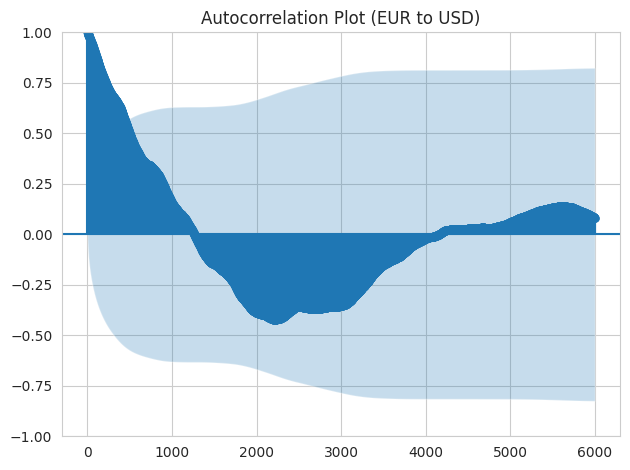

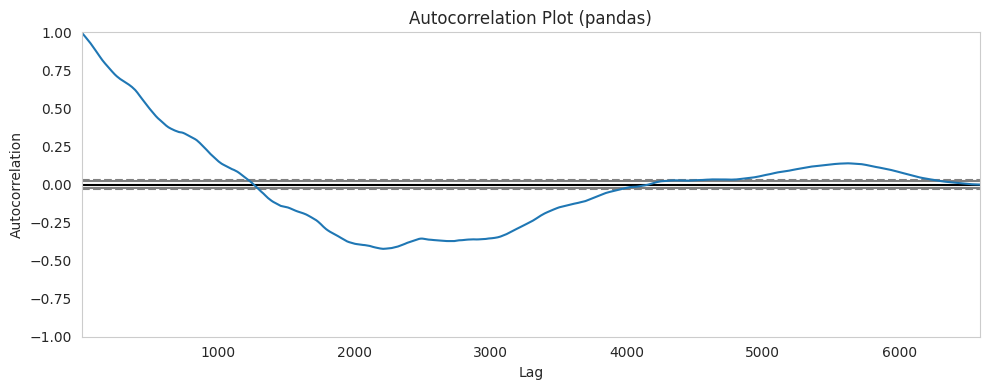

Augmented Dickey-Fuller Test:
ADF Statistic: -1.87751
p-value: 0.34271
Critical Values:
   1%: -3.43134
   5%: -2.86198
   10%: -2.56700
=> The data is likely non-stationary (fail to reject H0)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 4))
plot_acf(df_usd['[US dollar ]'], lags=6000)
plt.title('Autocorrelation Plot (EUR to USD)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
autocorrelation_plot(df_usd['[US dollar ]'])
plt.title('Autocorrelation Plot (pandas)')
plt.tight_layout()
plt.show()

adf_result = adfuller(df_usd['[US dollar ]'])

print('Augmented Dickey-Fuller Test:')
print(f'ADF Statistic: {adf_result[0]:.5f}')
print(f'p-value: {adf_result[1]:.5f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.5f}')
if adf_result[1] < 0.05:
    print('=> The data is likely stationary (reject H0)')
else:
    print('=> The data is likely non-stationary (fail to reject H0)')

Detrend using moving average

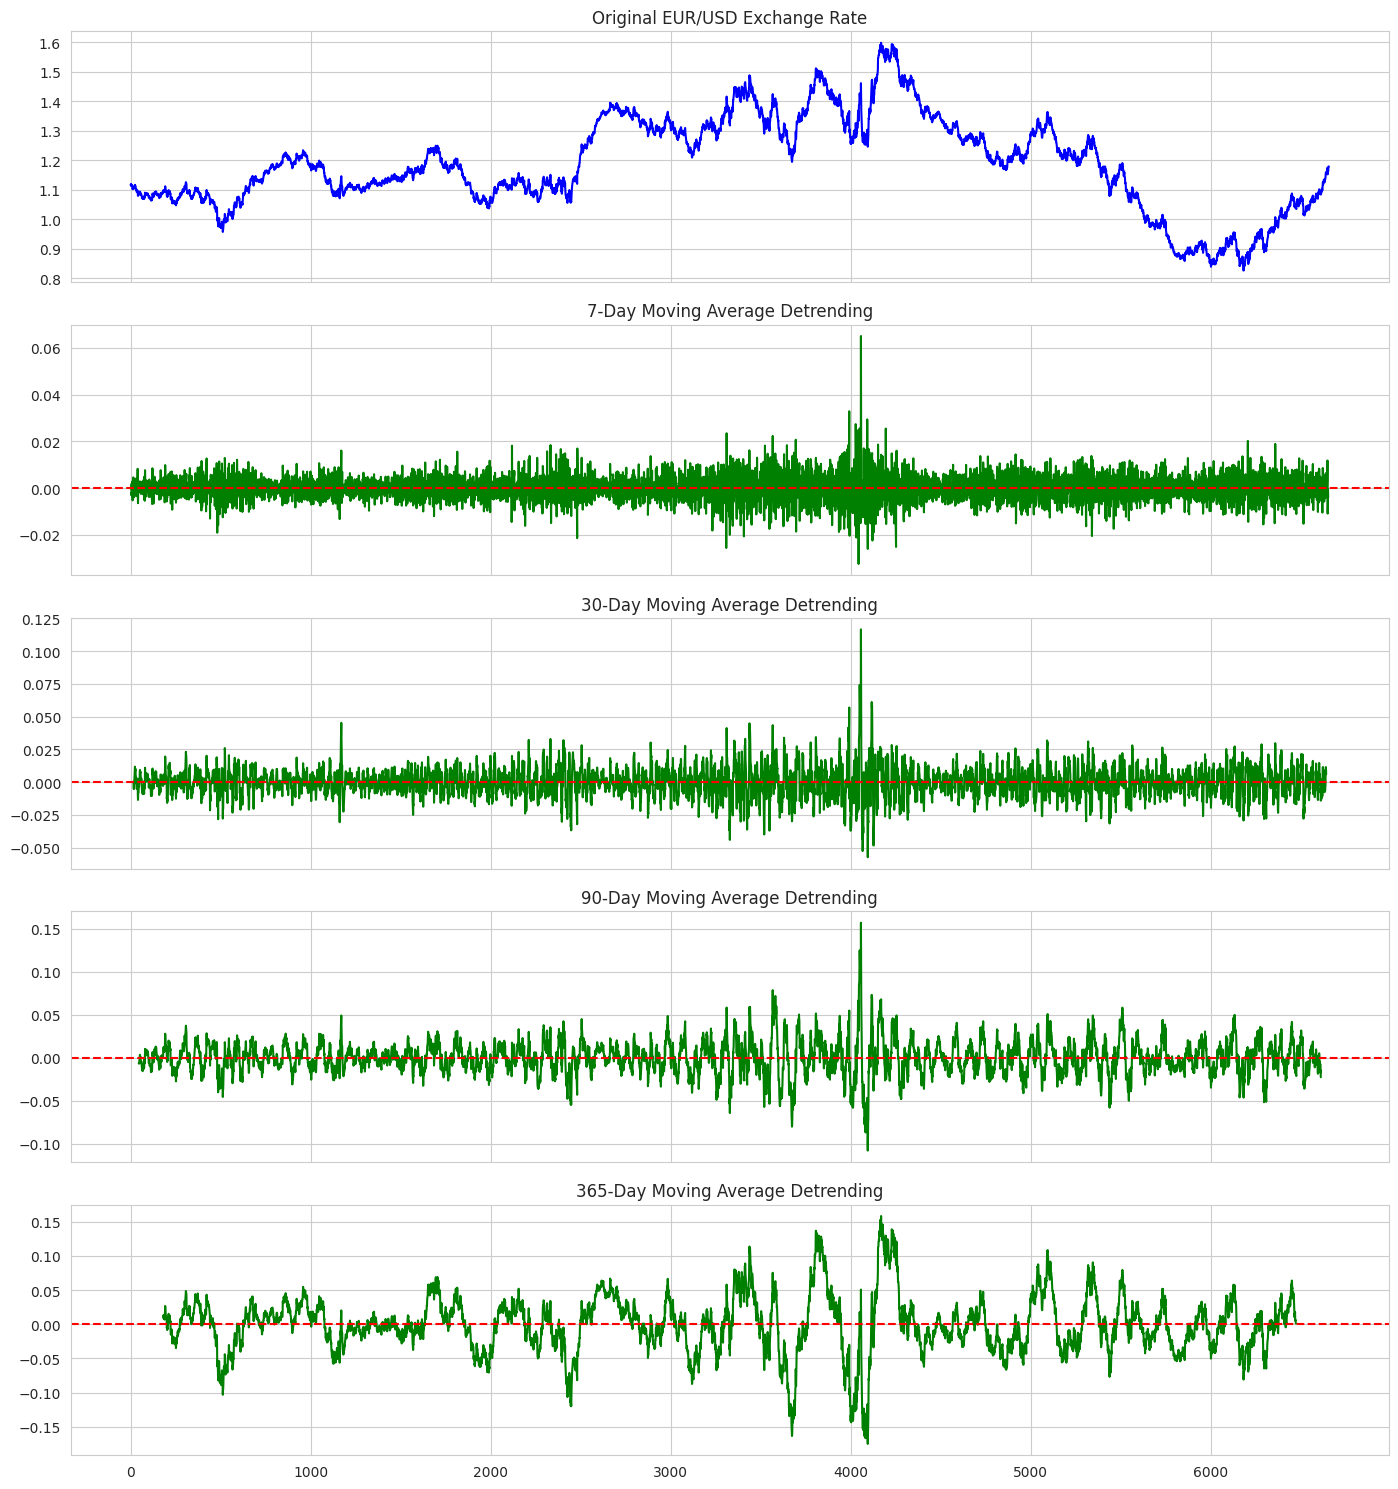


Stationarity Tests After Detrending:

7-Day MA Detrended:
ADF Statistic: -23.17873
p-value: 0.00000
=> Stationary (reject H0)

30-Day MA Detrended:
ADF Statistic: -19.19270
p-value: 0.00000
=> Stationary (reject H0)

90-Day MA Detrended:
ADF Statistic: -16.29778
p-value: 0.00000
=> Stationary (reject H0)

365-Day MA Detrended:
ADF Statistic: -6.70567
p-value: 0.00000
=> Stationary (reject H0)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

windows = [7, 30, 90, 365]

fig, axes = plt.subplots(nrows=len(windows)+1, ncols=1,
                        figsize=(14, 3*(len(windows)+1)),
                        sharex=True)

axes[0].plot(df_usd['[US dollar ]'], label='Original', color='blue')
axes[0].set_title('Original EUR/USD Exchange Rate')
axes[0].grid(True)

for i, window in enumerate(windows, start=1):
    ma = df_usd['[US dollar ]'].rolling(window=window, center=True).mean()

    detrended = df_usd['[US dollar ]'] - ma

    axes[i].plot(detrended, label=f'Detrended (Window={window})', color='green')
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f'{window}-Day Moving Average Detrending')
    axes[i].grid(True)

    df_usd[f'detrended_{window}'] = detrended

plt.tight_layout()
plt.show()

print("\nStationarity Tests After Detrending:")
for window in windows:
    adf_result = adfuller(df_usd[f'detrended_{window}'].dropna())
    print(f"\n{window}-Day MA Detrended:")
    print(f"ADF Statistic: {adf_result[0]:.5f}")
    print(f"p-value: {adf_result[1]:.5f}")
    if adf_result[1] < 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")

ACF of above detrend values

<Figure size 1400x600 with 0 Axes>

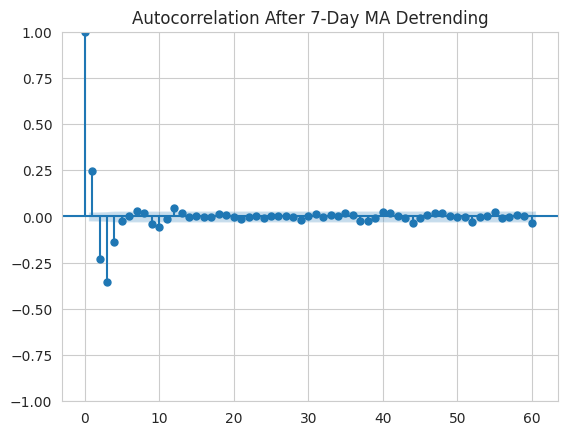

<Figure size 1400x600 with 0 Axes>

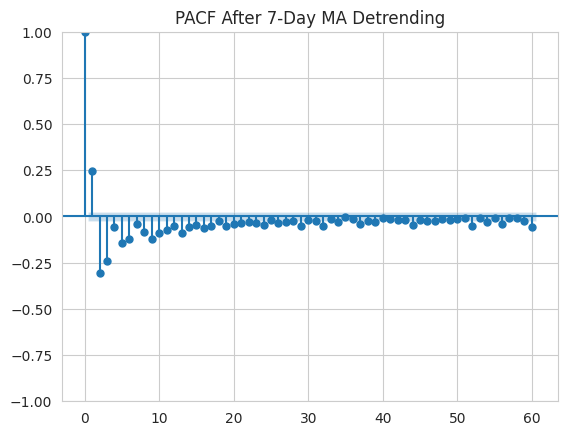

In [ ]:
best_window =  7
plt.figure(figsize=(14, 6))
plot_acf(df_usd[f'detrended_{best_window}'].dropna(), lags=60,
         title=f'Autocorrelation After {best_window}-Day MA Detrending')
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(df_usd[f'detrended_{best_window}'].dropna(), lags=60, title=f'PACF After {best_window}-Day MA Detrending')
plt.show()

  Rolling Mean and rolling SD of above detrend values

In [ ]:
for window in windows:
    detrended_col = f'detrended_{window}'

    df_usd[f'{detrended_col}_roll_mean'] = df_usd[detrended_col].rolling(window=window).mean()
    df_usd[f'{detrended_col}_roll_sd'] = df_usd[detrended_col].rolling(window=window).std()

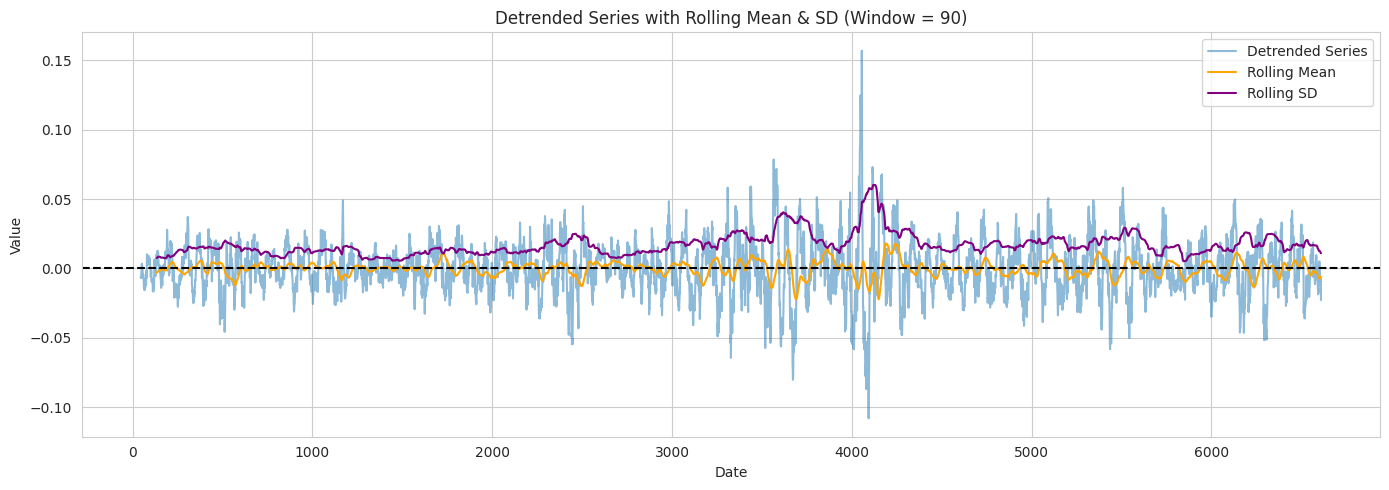

In [ ]:
example_window = 90
col = f'detrended_{example_window}'

plt.figure(figsize=(14, 5))
plt.plot(df_usd[col], label='Detrended Series', alpha=0.5)
plt.plot(df_usd[f'{col}_roll_mean'], label='Rolling Mean', color='orange')
plt.plot(df_usd[f'{col}_roll_sd'], label='Rolling SD', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title(f'Detrended Series with Rolling Mean & SD (Window = {example_window})')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Detrend using polynomial trend(Regression) and ACF of that data

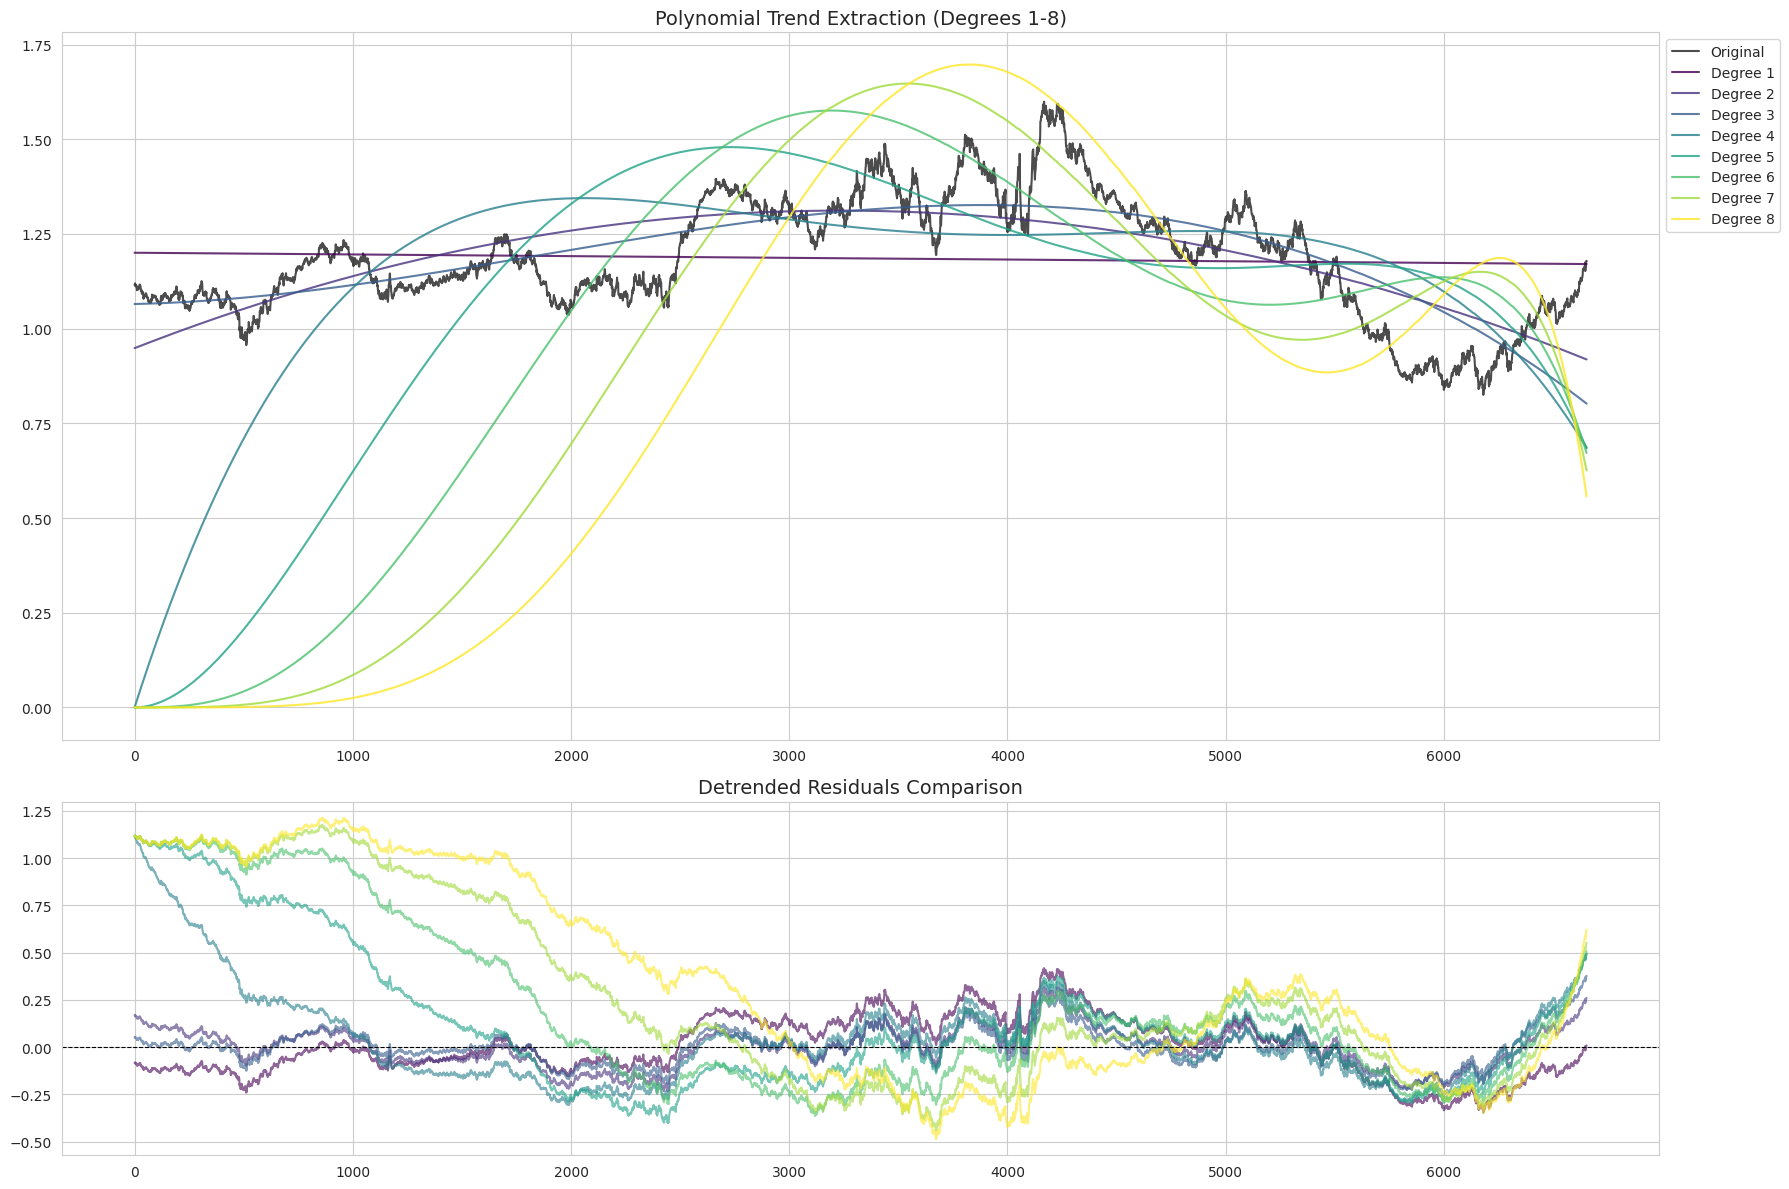

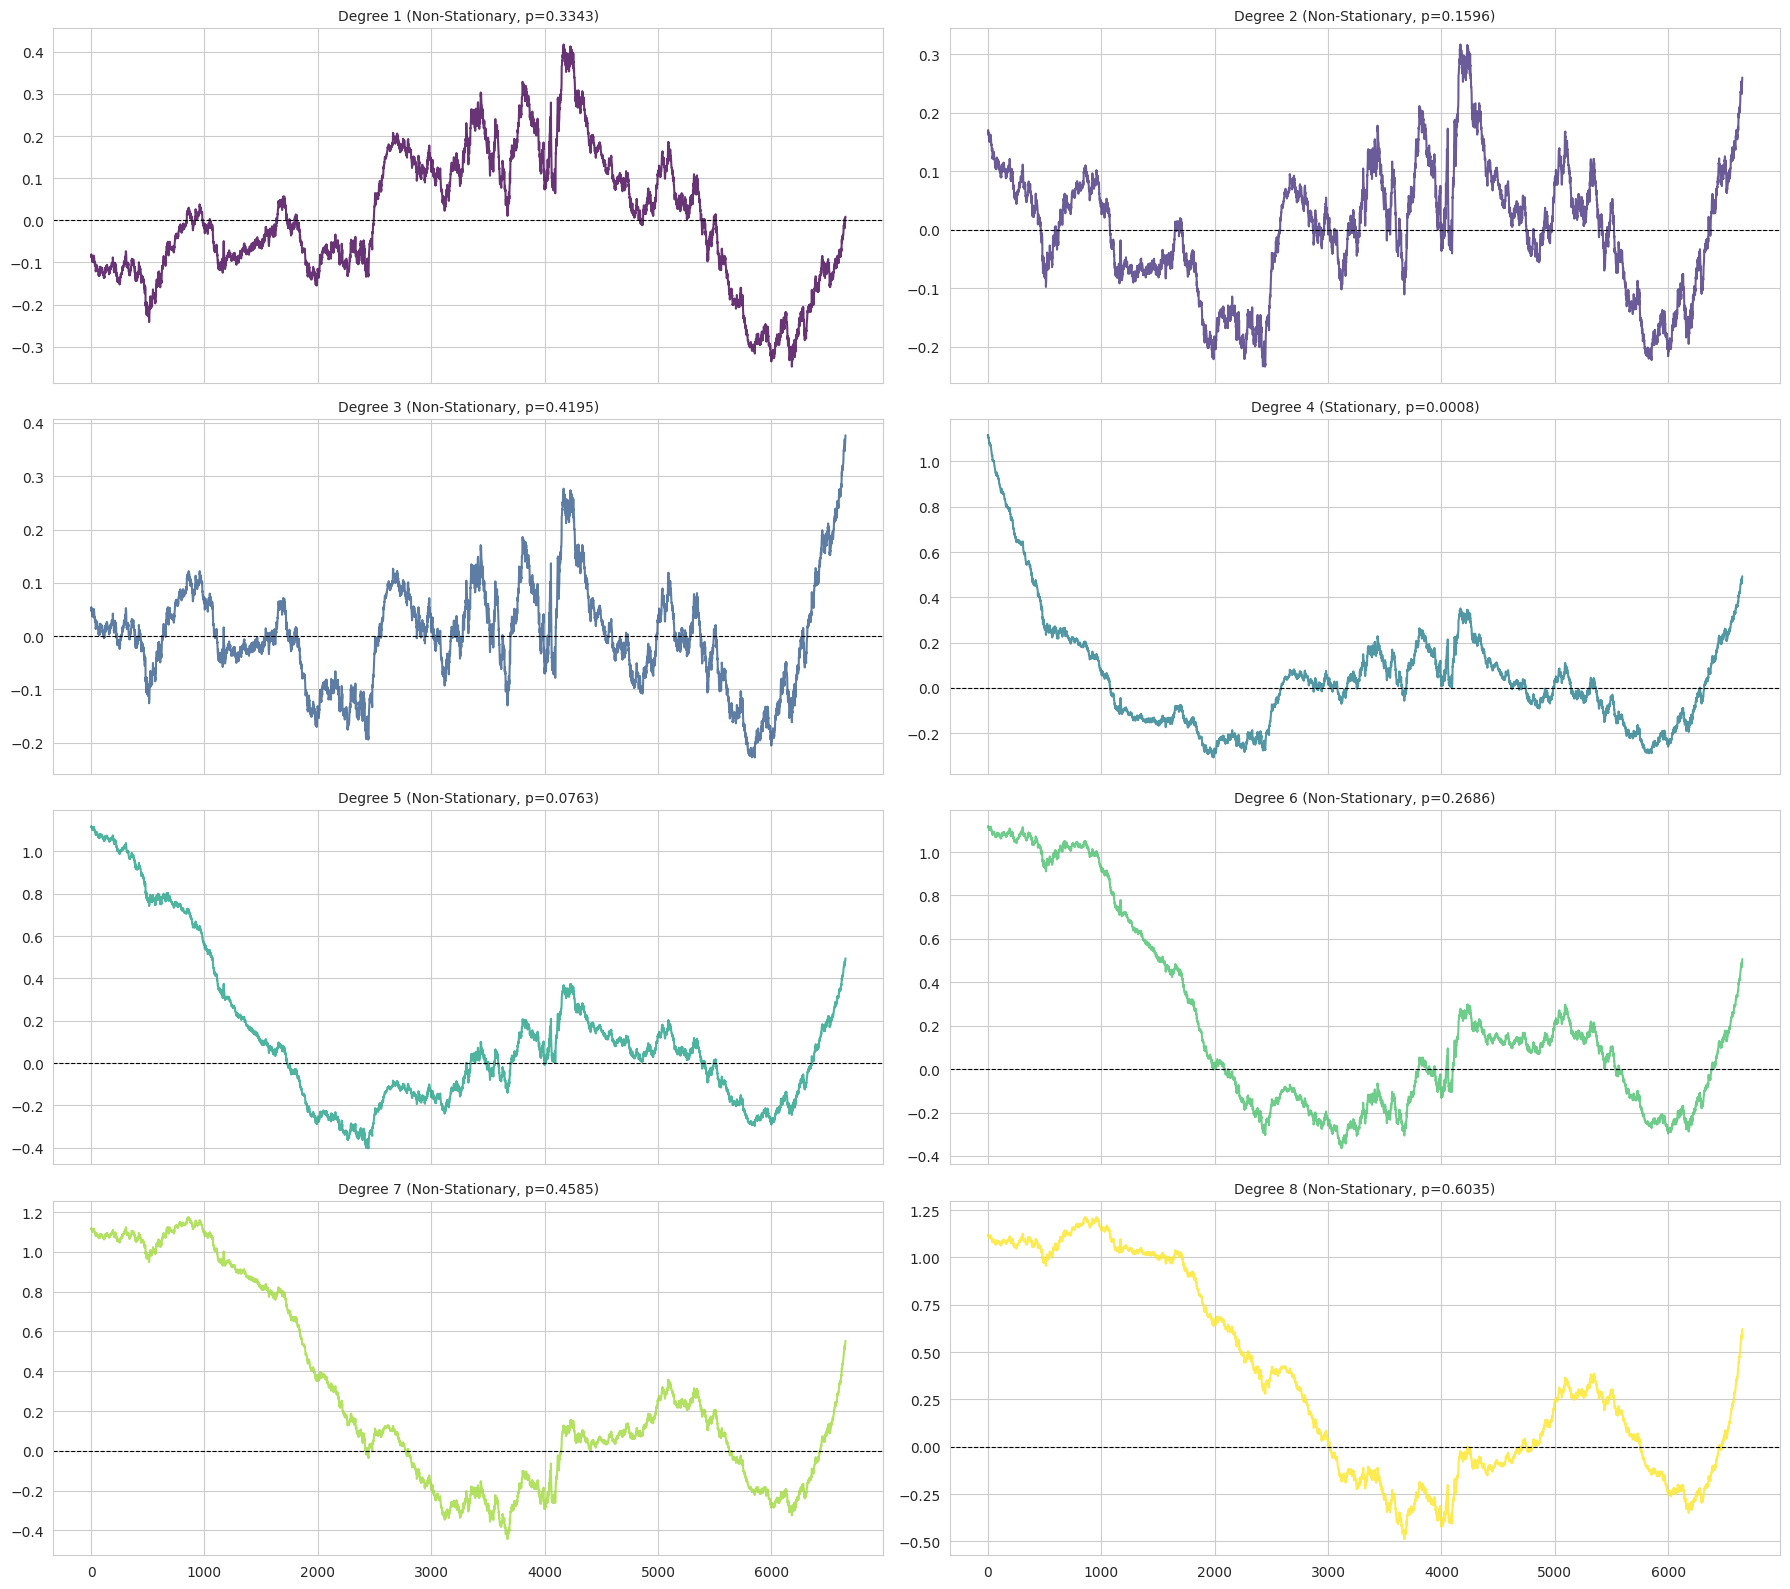


Polynomial Detrending Performance Comparison:
   Degree  ADF Statistic  p-value  Stationary    RMSE          BIC
0       1       -1.89524  0.33430       False 0.15541  -5820.40923
1       2       -2.33946  0.15956       False 0.10702 -10730.31196
2       3       -1.72253  0.41954       False 0.09753 -11946.68575
3       4       -4.15723  0.00078        True 0.25340    643.89758
4       5       -2.68736  0.07625       False 0.38698   6226.83695
5       6       -2.04172  0.26858       False 0.48239   9132.72416
6       7       -1.64725  0.45847       False 0.55724  11034.61300
7       8       -1.35540  0.60346       False 0.62052  12452.91747

Recommended polynomial degree: 4 (Lowest degree achieving stationarity)


<Figure size 1400x600 with 0 Axes>

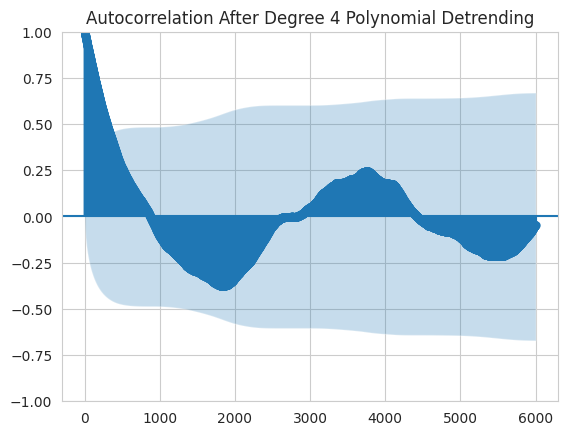

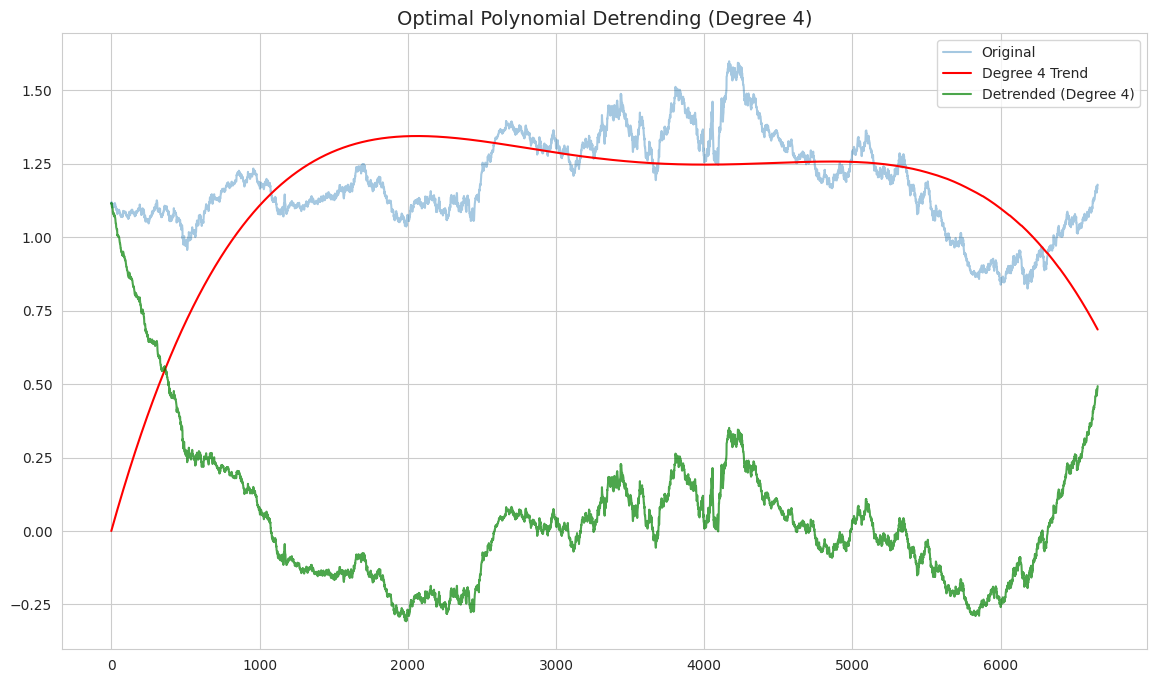

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.gridspec import GridSpec

X = np.arange(len(df_usd)).reshape(-1, 1)
y = df_usd['[US dollar ]'].values
dates = df_usd.index

degrees = range(1, 9)
colors = plt.cm.viridis(np.linspace(0, 1, len(degrees)))

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 1, height_ratios=[2, 1])

ax0 = plt.subplot(gs[0])
ax0.plot(dates, y, label='Original', color='black', linewidth=1.5, alpha=0.7)

ax1 = plt.subplot(gs[1], sharex=ax0)

for i, degree in enumerate(degrees):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = sm.OLS(y, X_poly).fit()
    trend = model.predict(X_poly)
    residual = y - trend

    df_usd[f'Poly{degree}_Trend'] = trend
    df_usd[f'Poly{degree}_Detrended'] = residual

    ax0.plot(dates, trend, label=f'Degree {degree}',
             color=colors[i], alpha=0.8, linewidth=1.5)

    ax1.plot(dates, residual, color=colors[i], alpha=0.6,
             label=f'Degree {degree}')

ax0.set_title('Polynomial Trend Extraction (Degrees 1-8)', fontsize=14)
ax0.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax0.grid(True)

ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.set_title('Detrended Residuals Comparison', fontsize=14)
ax1.grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(18, 16), sharex=True)
axes = axes.flatten()

for i, degree in enumerate(degrees):
    residual = df_usd[f'Poly{degree}_Detrended']

    axes[i].plot(dates, residual, color=colors[i], alpha=0.8)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[i].set_title(f'Degree {degree} Residuals', fontsize=12)
    axes[i].grid(True)

    adf_result = adfuller(residual.dropna())
    pval = adf_result[1]
    stationarity = "Stationary" if pval < 0.05 else "Non-Stationary"
    axes[i].set_title(f'Degree {degree} ({stationarity}, p={pval:.4f})', fontsize=10)

plt.tight_layout()
plt.show()

results = []
for degree in degrees:
    residual = df_usd[f'Poly{degree}_Detrended'].dropna()
    adf_result = adfuller(residual)

    rmse = np.sqrt(np.mean(residual**2))

    results.append({
        'Degree': degree,
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05,
        'RMSE': rmse,
        'BIC': sm.OLS(y, PolynomialFeatures(degree).fit_transform(X)).fit().bic
    })

results_df = pd.DataFrame(results)
print("\nPolynomial Detrending Performance Comparison:")
print(results_df.to_string(float_format="%.5f"))

best_degree = results_df.loc[results_df['Stationary'], 'Degree'].min()
print(f"\nRecommended polynomial degree: {best_degree} (Lowest degree achieving stationarity)")

plt.figure(figsize=(14, 6))
plot_acf(df_usd[f'Poly{best_degree}_Detrended'].dropna(), lags=6000,
         title=f'Autocorrelation After Degree {best_degree} Polynomial Detrending')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(dates, y, label='Original', alpha=0.4)
plt.plot(dates, df_usd[f'Poly{best_degree}_Trend'],
         label=f'Degree {best_degree} Trend', color='red')
plt.plot(dates, df_usd[f'Poly{best_degree}_Detrended'],
         label=f'Detrended (Degree {best_degree})', color='green', alpha=0.7)
plt.title(f'Optimal Polynomial Detrending (Degree {best_degree})', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Detrend using differencing methood and ACF of that data

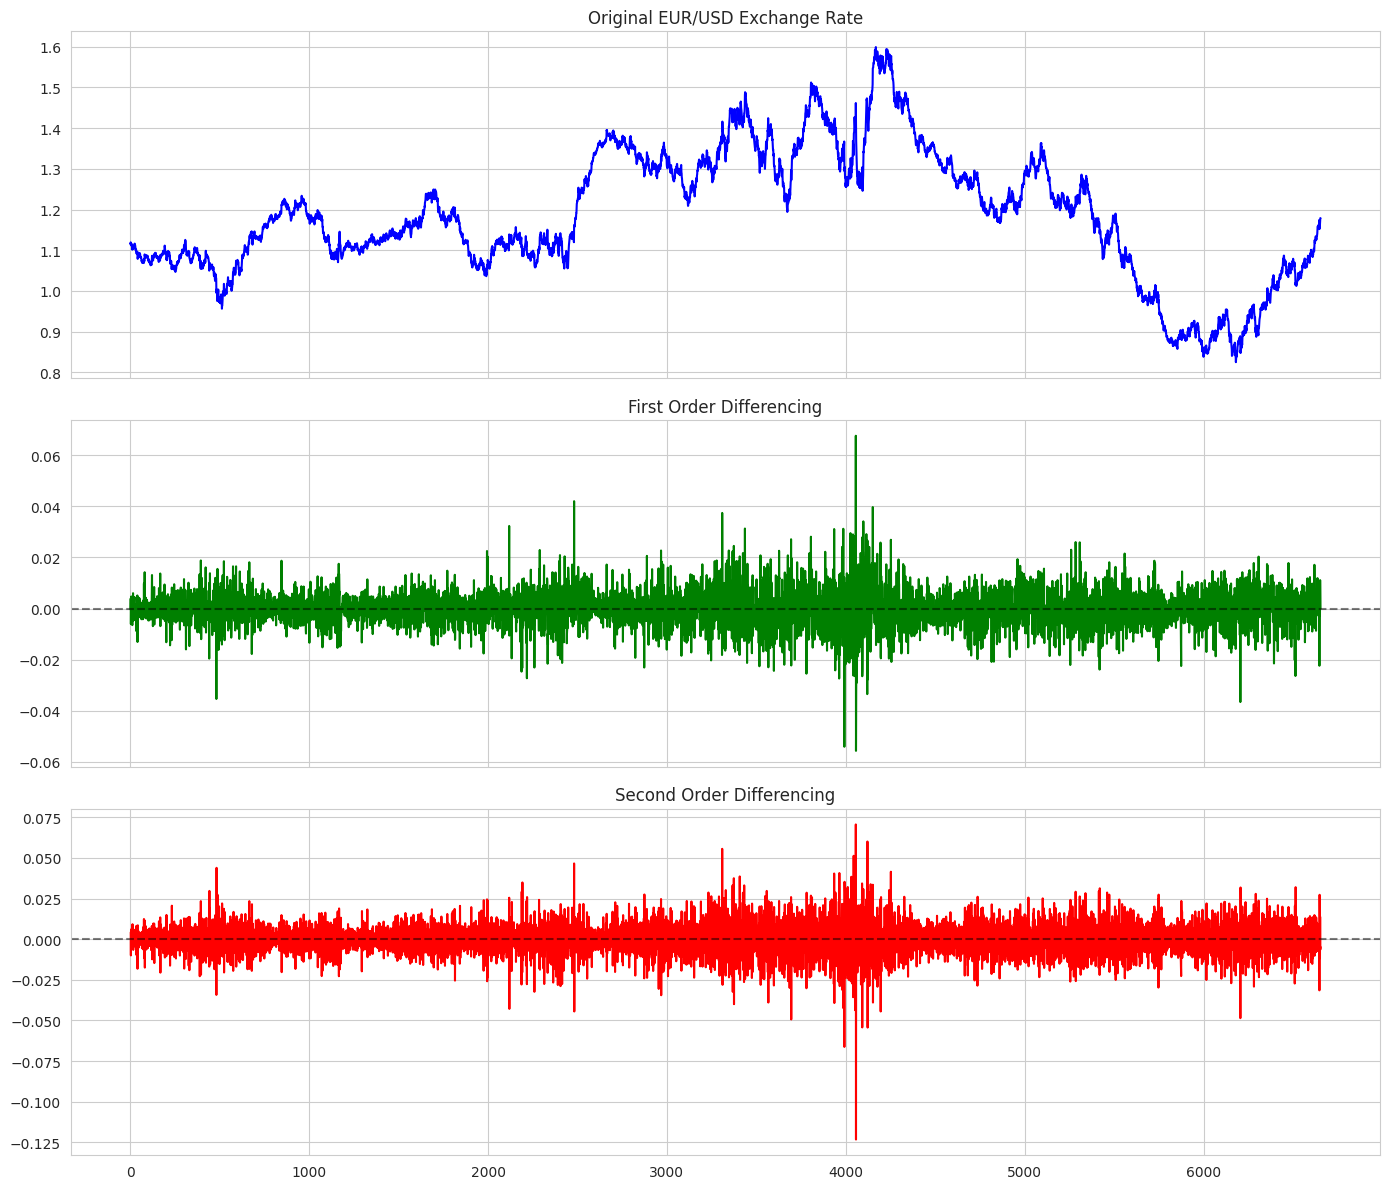


Original Series:
ADF Statistic: -1.87751
p-value: 0.34271
Critical Values:
   1%: -3.43134
   5%: -2.86198
   10%: -2.56700
=> Non-stationary (fail to reject H0)

First Differences:
ADF Statistic: -23.22191
p-value: 0.00000
Critical Values:
   1%: -3.43134
   5%: -2.86198
   10%: -2.56700
=> Stationary (reject H0)


<Figure size 1400x400 with 0 Axes>

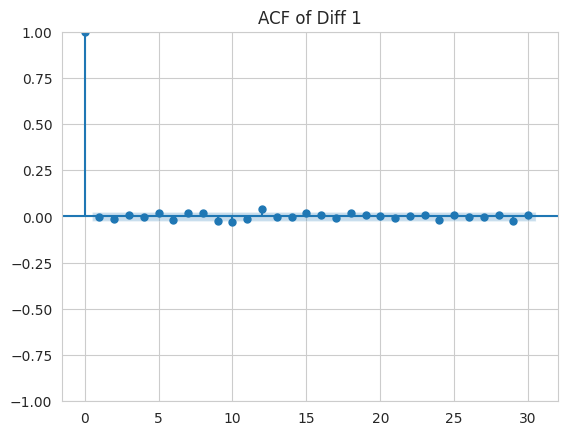

<Figure size 1400x400 with 0 Axes>

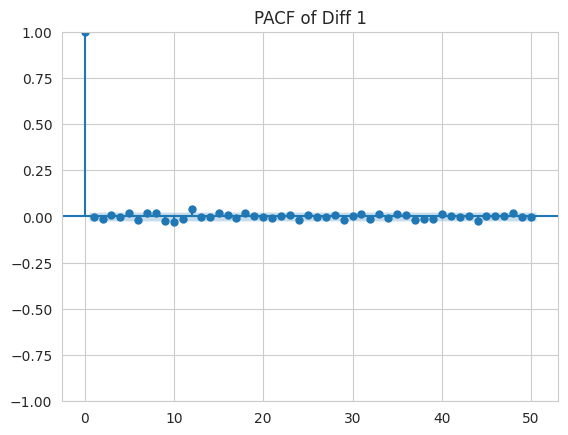


Final detrended series (diff 1):
Mean: 0.000010
Std Dev: 0.007040


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_usd['diff_1'] = df_usd['[US dollar ]'].diff()
df_usd['diff_2'] = df_usd['diff_1'].diff()

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(df_usd['[US dollar ]'], label='Original', color='blue')
axes[0].set_title('Original EUR/USD Exchange Rate')
axes[0].grid(True)

axes[1].plot(df_usd['diff_1'], label='First Differences', color='green')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_title('First Order Differencing')
axes[1].grid(True)

axes[2].plot(df_usd['diff_2'], label='Second Differences', color='red')
axes[2].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[2].set_title('Second Order Differencing')
axes[2].grid(True)

plt.tight_layout()
plt.show()

def check_stationarity(series, name):
    adf_result = adfuller(series.dropna())
    print(f"\n{name}:")
    print(f"ADF Statistic: {adf_result[0]:.5f}")
    print(f"p-value: {adf_result[1]:.5f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.5f}")
    if adf_result[1] < 0.05:
        print("=> Stationary (reject H0)")
        return True
    else:
        print("=> Non-stationary (fail to reject H0)")
        return False

check_stationarity(df_usd['[US dollar ]'], "Original Series")
is_stationary = check_stationarity(df_usd['diff_1'], "First Differences")

if not is_stationary:
    check_stationarity(df_usd['diff_2'], "Second Differences")

best_diff = 'diff_2' if not is_stationary else 'diff_1'
plt.figure(figsize=(14, 4))
plot_acf(df_usd[best_diff].dropna(), lags=30, title=f'ACF of {best_diff.replace("_", " ").title()}')
plt.show()

plt.figure(figsize=(14, 4))
plot_pacf(df_usd[best_diff].dropna(), lags=50, title=f'PACF of {best_diff.replace("_", " ").title()}')
plt.show()

final_detrended = df_usd[best_diff].dropna()
print(f"\nFinal detrended series ({best_diff.replace('_', ' ')}):")
print(f"Mean: {final_detrended.mean():.6f}")
print(f"Std Dev: {final_detrended.std():.6f}")

Check of seasonality using ACF pattern

<Figure size 1000x400 with 0 Axes>

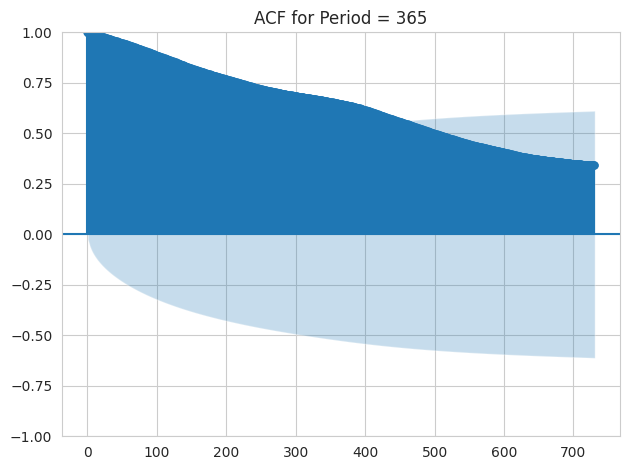

Period: 365 ‚û§ Seasonality Strength = 0.0549
‚ùå Weak or No Seasonality Detected
--------------------------------------------------


<Figure size 1000x400 with 0 Axes>

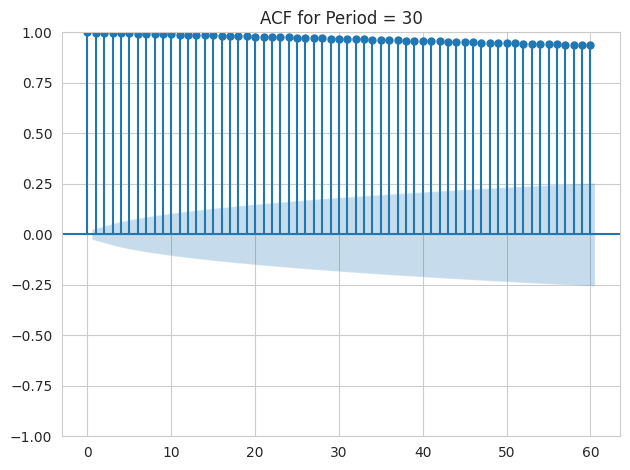

Period: 30 ‚û§ Seasonality Strength = 0.0068
‚ùå Weak or No Seasonality Detected
--------------------------------------------------


<Figure size 1000x400 with 0 Axes>

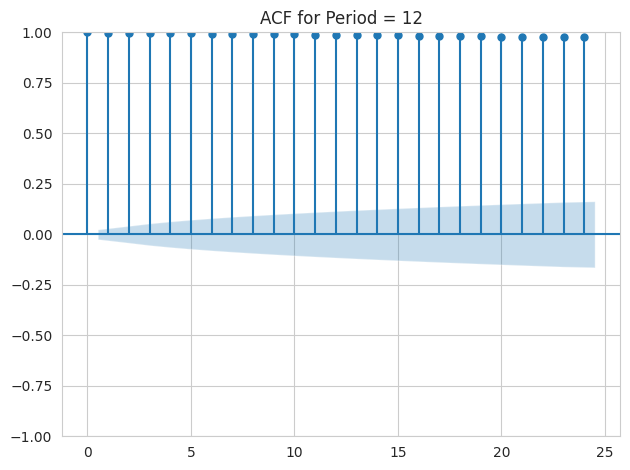

Period: 12 ‚û§ Seasonality Strength = 0.0011
‚ùå Weak or No Seasonality Detected
--------------------------------------------------


<Figure size 1000x400 with 0 Axes>

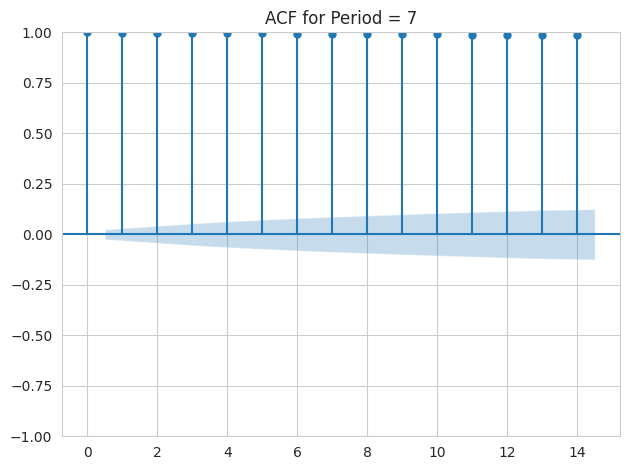

Period: 7 ‚û§ Seasonality Strength = 0.0010
‚ùå Weak or No Seasonality Detected
--------------------------------------------------

üîç Best detected seasonality period = 365 days with strength = 0.0549


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

df_usd.sort_values('Date', inplace=True)

series = df_usd['[US dollar ]']

periods_to_try = [365, 30, 12, 7]
seasonality_results = []

for period in periods_to_try:
    if len(series) >= 2 * period:
        try:
            decomposition = seasonal_decompose(series, model='additive', period=period)
            seasonal = decomposition.seasonal.dropna()
            residual = decomposition.resid.dropna()

            valid_index = seasonal.index.intersection(residual.index)
            seasonal = seasonal.loc[valid_index]
            residual = residual.loc[valid_index]

            var_s = np.var(seasonal)
            var_sr = np.var(seasonal + residual)
            strength = var_s / var_sr

            seasonality_results.append((period, strength))

            plt.figure(figsize=(10, 4))
            plot_acf(series, lags=2 * period)
            plt.title(f'ACF for Period = {period}')
            plt.tight_layout()
            plt.show()

            print(f"Period: {period} ‚û§ Seasonality Strength = {strength:.4f}")
            if strength > 0.6:
                print("‚úÖ Strong Seasonality Detected")
            elif strength > 0.3:
                print("‚ö†Ô∏è Moderate Seasonality Detected")
            else:
                print("‚ùå Weak or No Seasonality Detected")
            print('-' * 50)

        except Exception as e:
            print(f"Error for period {period}: {e}")
    else:
        print(f"‚ö†Ô∏è Not enough data for period = {period} (required: {2*period}, available: {len(series)})")

if seasonality_results:
    best_period, best_strength = max(seasonality_results, key=lambda x: x[1])
    print(f"\nüîç Best detected seasonality period = {best_period} days with strength = {best_strength:.4f}")
else:
    print("‚ùå No seasonality detected due to insufficient data.")

# `LOG-NORMAL(Data Transformation)`

  Log transformation and decomposition of this data

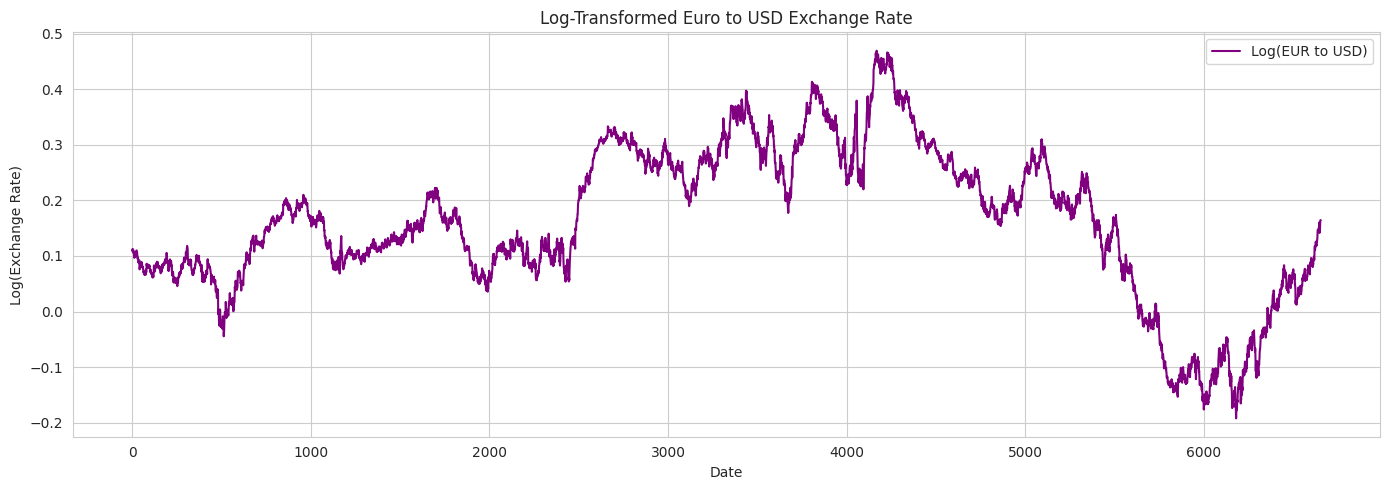

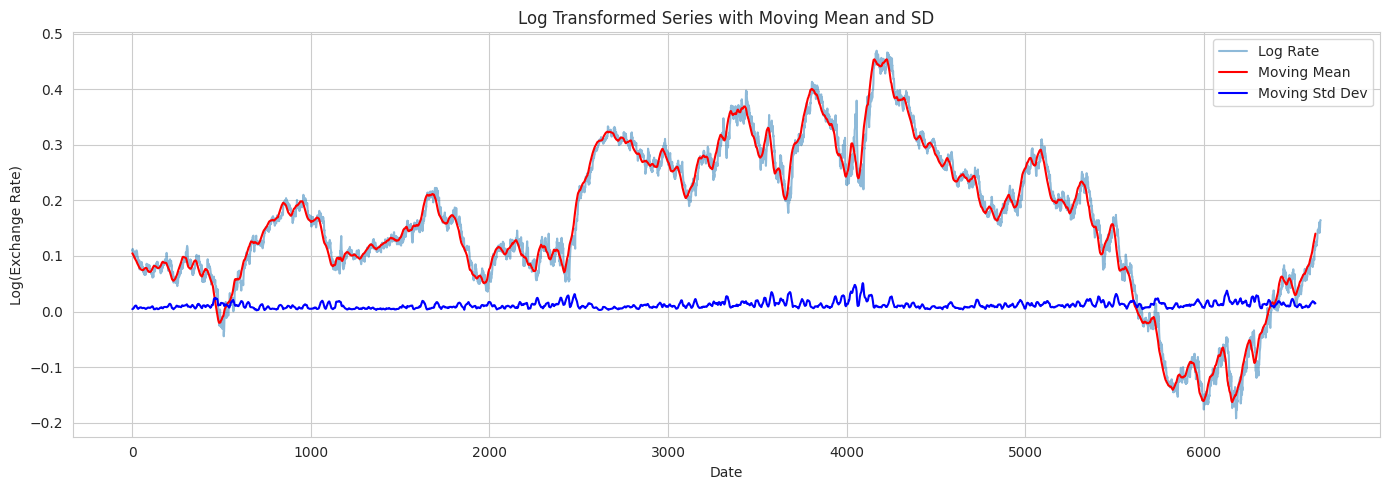


ADF Test on Log-Transformed Series:
ADF Statistic: -1.75577
p-value: 0.40263
  Critical Value (1%): -3.43134
  Critical Value (5%): -2.86198
  Critical Value (10%): -2.56700
‚ùå Non-stationary (Fail to Reject H0)


<Figure size 1000x400 with 0 Axes>

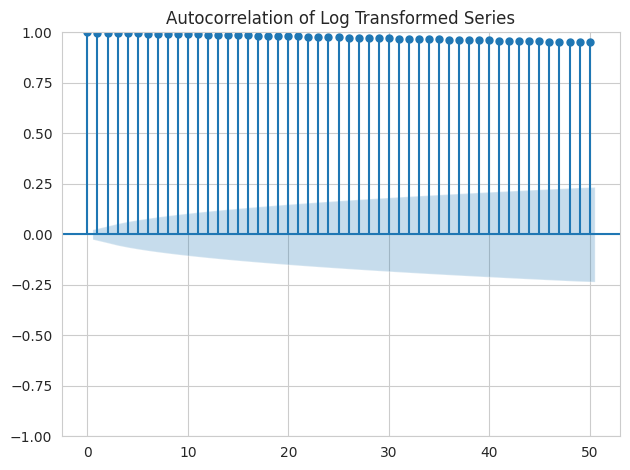

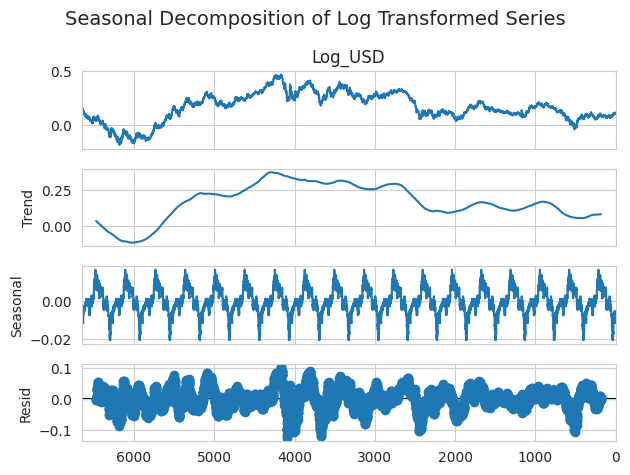

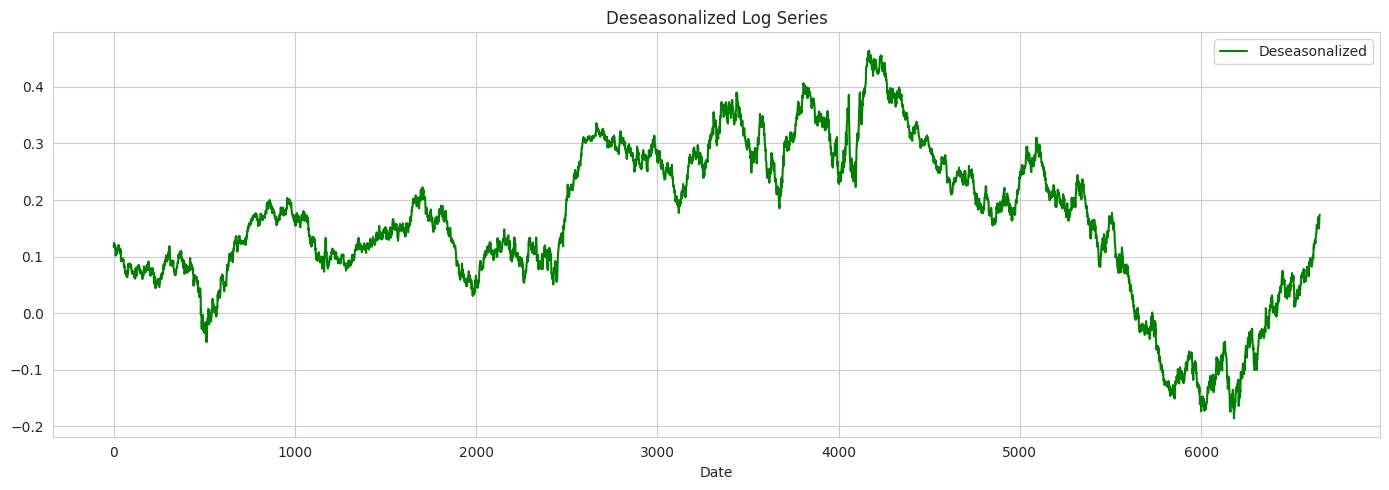

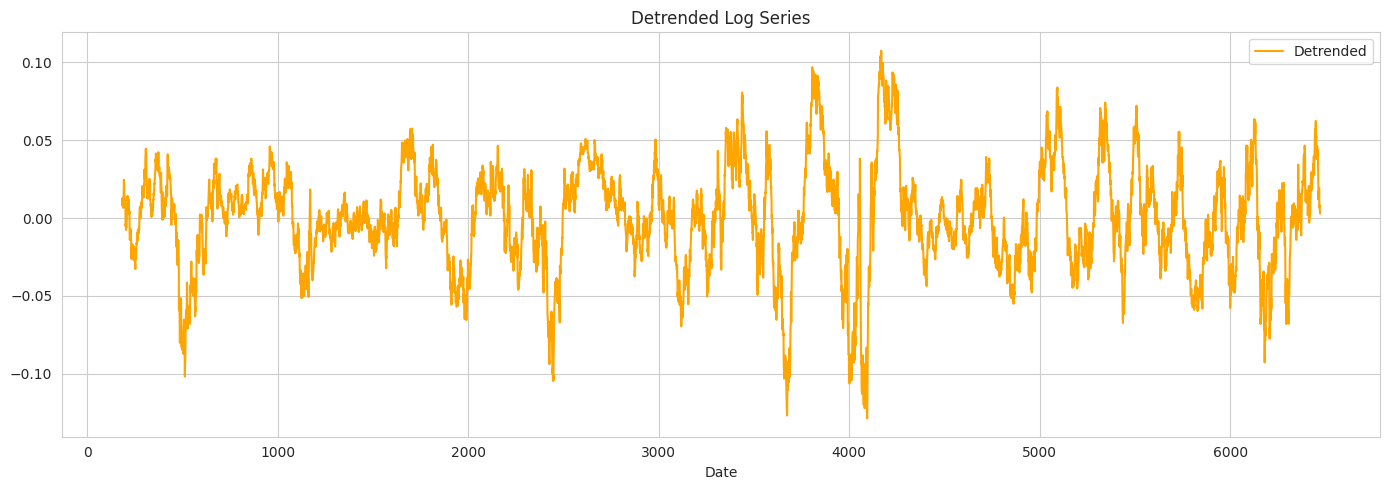

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

df_log = df_usd.copy()
df_log['Log_USD'] = np.log(df_log['[US dollar ]'])

plt.figure(figsize=(14, 5))
plt.plot(df_log.index, df_log['Log_USD'], color='purple', label='Log(EUR to USD)')
plt.title('Log-Transformed Euro to USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Log(Exchange Rate)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

window = 30
df_log['Moving_Mean'] = df_log['Log_USD'].rolling(window=window).mean()
df_log['Moving_SD'] = df_log['Log_USD'].rolling(window=window).std()

plt.figure(figsize=(14, 5))
plt.plot(df_log['Log_USD'], label='Log Rate', alpha=0.5)
plt.plot(df_log['Moving_Mean'], label='Moving Mean', color='red')
plt.plot(df_log['Moving_SD'], label='Moving Std Dev', color='blue')
plt.title('Log Transformed Series with Moving Mean and SD')
plt.xlabel('Date')
plt.ylabel('Log(Exchange Rate)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

adf_result = adfuller(df_log['Log_USD'].dropna())
print("\nADF Test on Log-Transformed Series:")
print(f"ADF Statistic: {adf_result[0]:.5f}")
print(f"p-value: {adf_result[1]:.5f}")
for key, val in adf_result[4].items():
    print(f"  Critical Value ({key}): {val:.5f}")
if adf_result[1] < 0.05:
    print("‚úÖ Stationary (Reject H0)")
else:
    print("‚ùå Non-stationary (Fail to Reject H0)")

plt.figure(figsize=(10, 4))
plot_acf(df_log['Log_USD'].dropna(), lags=50)
plt.title('Autocorrelation of Log Transformed Series')
plt.tight_layout()
plt.show()

log_series = df_log['Log_USD'].dropna()
decomposition = seasonal_decompose(log_series, model='additive', period=365)

decomposition.plot()
plt.suptitle('Seasonal Decomposition of Log Transformed Series', fontsize=14)
plt.tight_layout()
plt.show()

deseasonalized = log_series - decomposition.seasonal
detrended = log_series - decomposition.trend

plt.figure(figsize=(14, 5))
plt.plot(deseasonalized, label='Deseasonalized', color='green')
plt.title('Deseasonalized Log Series')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(detrended, label='Detrended', color='orange')
plt.title('Detrended Log Series')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Checking stationarity of log returns using ADF

In [ ]:
from statsmodels.tsa.stattools import adfuller

df_log['First_Diff'] = df_log['Log_USD'].diff()
log_returns = df_log['First_Diff'].dropna()

adf_result = adfuller(log_returns)
print("\nAugmented Dickey-Fuller Test:")
print(f"  ADF Statistic = {adf_result[0]:.5f}")
print(f"  p-value = {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("  => Log returns are stationary (reject H0)")
else:
    print("  => Log returns are NOT stationary (fail to reject H0)")


Augmented Dickey-Fuller Test:
  ADF Statistic = -23.35704
  p-value = 0.00000
  => Log returns are stationary (reject H0)


Plot of log returns(Stationary data), ACF of this data and Yule-Walker Method for PACF

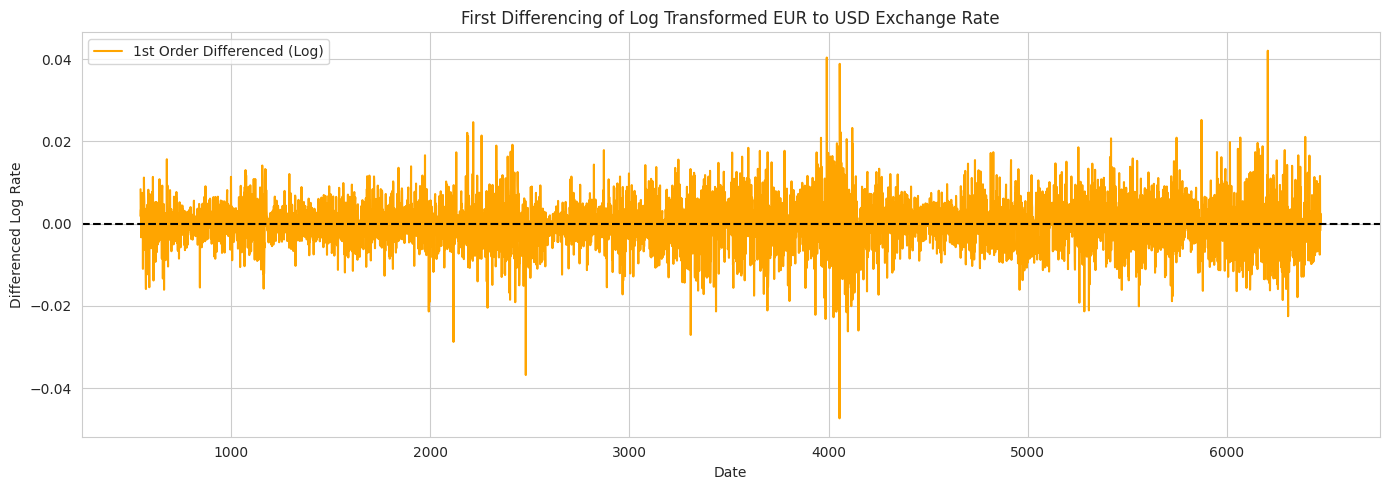


ADF Test on First-Differenced Log Series:
ADF Statistic: -21.93014
p-value: 0.00000
  Critical Value (1%): -3.43147
  Critical Value (5%): -2.86203
  Critical Value (10%): -2.56703
‚úÖ Stationary (Reject H0)


<Figure size 1000x400 with 0 Axes>

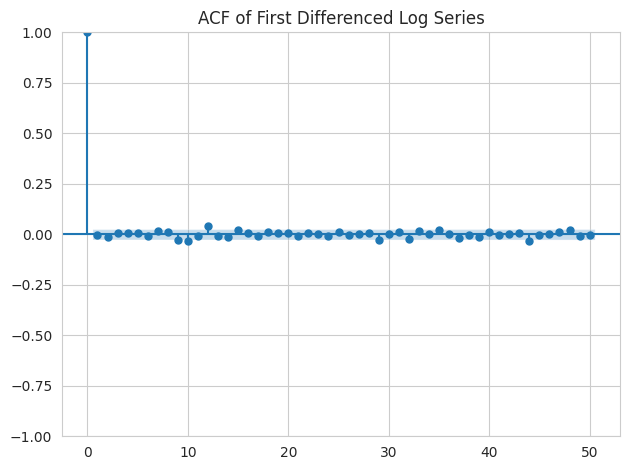

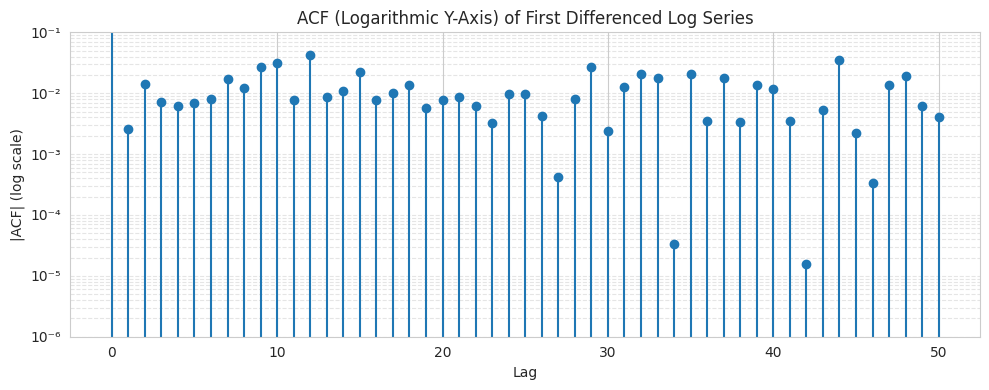

<Figure size 1000x400 with 0 Axes>

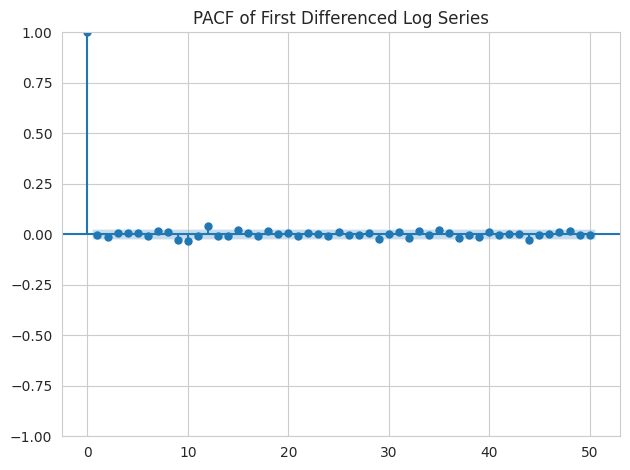

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

df_log['First_Diff'] = df_log['Log_USD'].diff()

df_log.dropna(inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(df_log.index, df_log['First_Diff'], label='1st Order Differenced (Log)', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('First Differencing of Log Transformed EUR to USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Differenced Log Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

adf_result = adfuller(df_log['First_Diff'])

print('\nADF Test on First-Differenced Log Series:')
print(f"ADF Statistic: {adf_result[0]:.5f}")
print(f"p-value: {adf_result[1]:.5f}")
for key, val in adf_result[4].items():
    print(f"  Critical Value ({key}): {val:.5f}")
if adf_result[1] < 0.05:
    print("‚úÖ Stationary (Reject H0)")
else:
    print("‚ùå Non-stationary (Fail to Reject H0)")

plt.figure(figsize=(10, 4))
plot_acf(df_log['First_Diff'], lags=50)
plt.title('ACF of First Differenced Log Series')
plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import acf
import numpy as np
import matplotlib.pyplot as plt

acf_values = acf(df_log['First_Diff'], nlags=50)

acf_abs = np.abs(acf_values)

plt.figure(figsize=(10, 4))
markerline, stemlines, baseline = plt.stem(range(len(acf_abs)), acf_abs, basefmt=" ")

plt.yscale('log')
plt.ylim(1e-6, 1e-1)

plt.yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
           ['10‚Åª¬π', '10‚Åª¬≤', '10‚Åª¬≥', '10‚Åª‚Å¥', '10‚Åª‚Åµ', '10‚Åª‚Å∂'])

plt.ylabel('|ACF| (log scale)')
plt.xlabel('Lag')
plt.title('ACF (Logarithmic Y-Axis) of First Differenced Log Series')
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df_log['First_Diff'], lags=50, method='ywm')  # Yule-Walker method
plt.title('PACF of First Differenced Log Series')
plt.tight_layout()
plt.show()

Histogram of log returns data

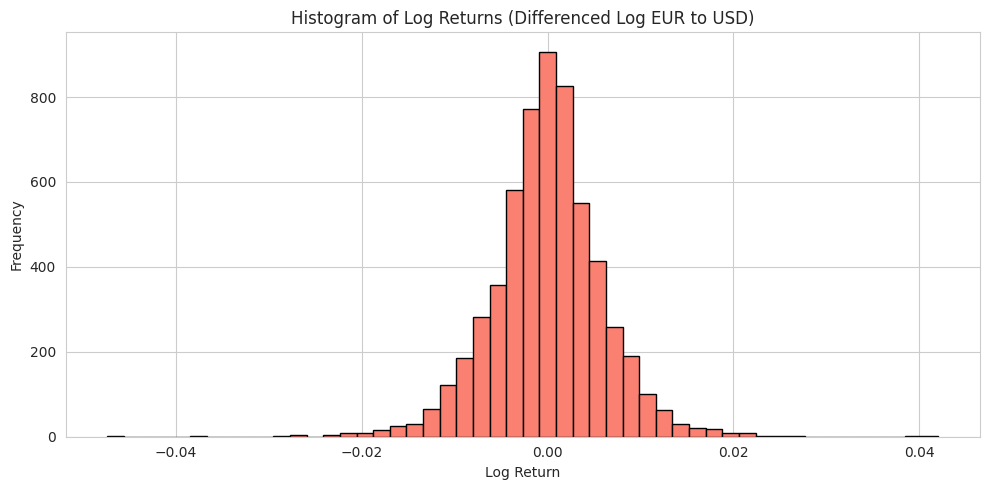

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df_log['First_Diff'], bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Log Returns (Differenced Log EUR to USD)')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

QQ plot of log returns data

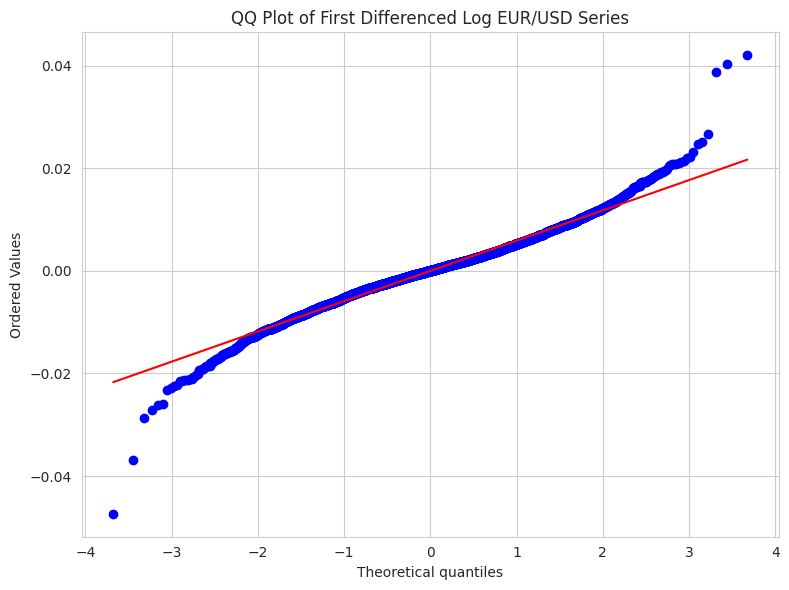

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
stats.probplot(df_log['First_Diff'], dist="norm", plot=plt)
plt.title('QQ Plot of First Differenced Log EUR/USD Series')
plt.grid(True)
plt.tight_layout()
plt.show()

Skewness and kurtosis of log returns

In [ ]:
from scipy.stats import skew, kurtosis

log_returns = df_log['First_Diff'].dropna()

skew_val = skew(log_returns)
kurt_val = kurtosis(log_returns, fisher=False)

print(f"Skewness of Log Returns: {skew_val:.5f}")
print(f"Kurtosis of Log Returns: {kurt_val:.5f}")

Skewness of Log Returns: -0.02182
Kurtosis of Log Returns: 6.08265


Histogram of log returns follow which distribution?

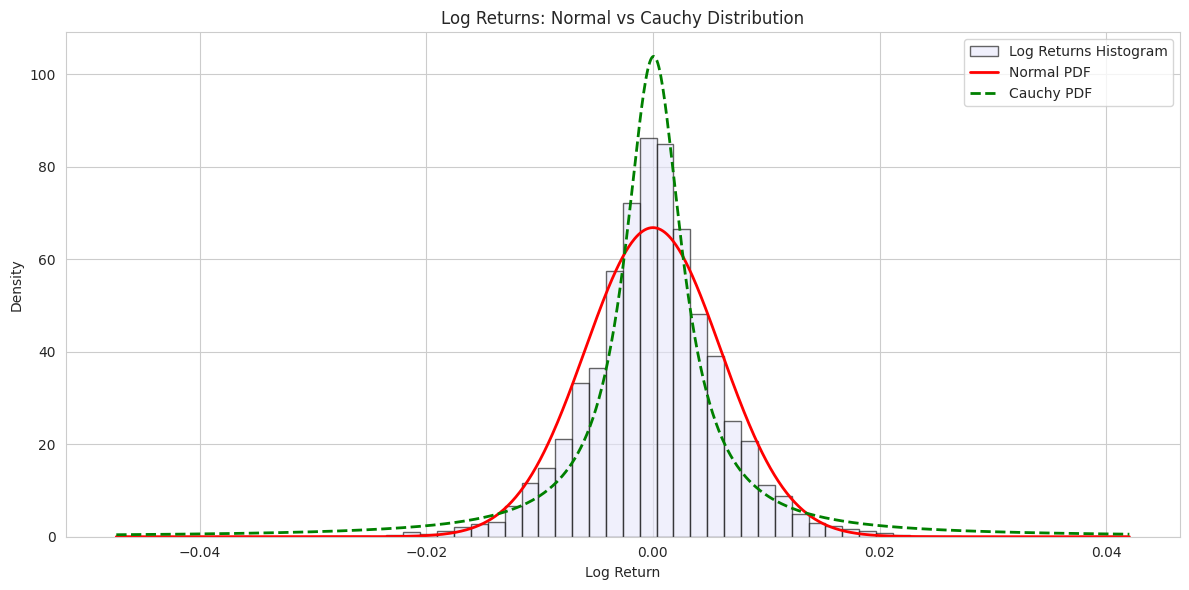

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy

log_returns = df_log['First_Diff'].dropna()

x = np.linspace(log_returns.min(), log_returns.max(), 1000)

mean_norm = np.mean(log_returns)
std_norm = np.std(log_returns)
pdf_norm = norm.pdf(x, loc=mean_norm, scale=std_norm)

loc_cauchy, scale_cauchy = cauchy.fit(log_returns)
pdf_cauchy = cauchy.pdf(x, loc=loc_cauchy, scale=scale_cauchy)

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=60, density=True, color='lavender', edgecolor='black', alpha=0.6, label='Log Returns Histogram')

plt.plot(x, pdf_norm, 'r-', label='Normal PDF', linewidth=2)
plt.plot(x, pdf_cauchy, 'g--', label='Cauchy PDF', linewidth=2)

plt.title('Log Returns: Normal vs Cauchy Distribution')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ACF of log returns data

<Figure size 1000x400 with 0 Axes>

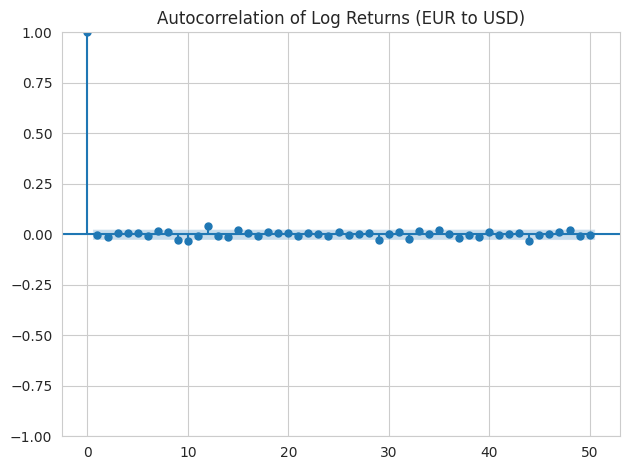

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

log_returns = df_log['First_Diff'].dropna()

plt.figure(figsize=(10, 4))
plot_acf(log_returns, lags=50, alpha=0.05)
plt.title('Autocorrelation of Log Returns (EUR to USD)')
plt.tight_layout()
plt.show()

Histogram of log data

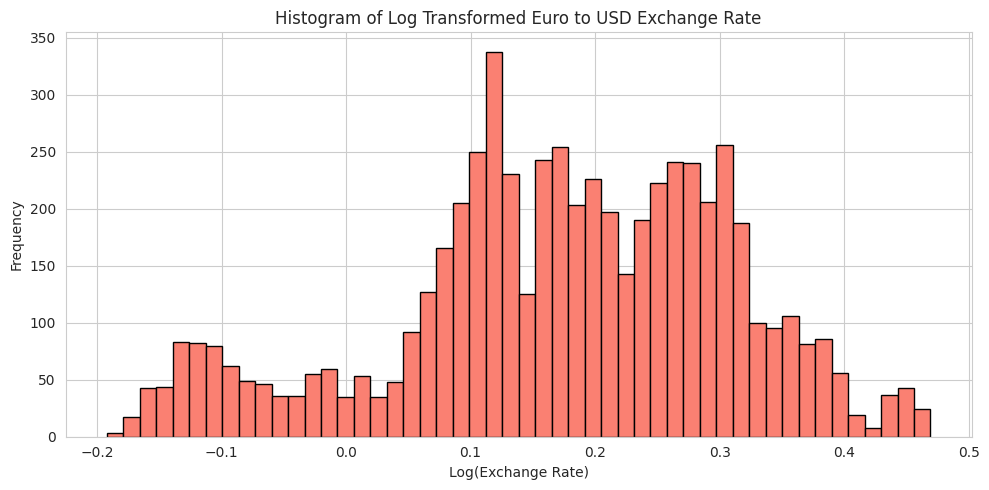

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df_log['Log_USD'].dropna(), bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Log Transformed Euro to USD Exchange Rate')
plt.xlabel('Log(Exchange Rate)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# `Try and error method to show some AR/MA property`

AR(2) and MA(2) model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

stationary_series = df_log['First_Diff']

ar_model = ARIMA(stationary_series, order=(2, 0, 0))
ar_result = ar_model.fit()
print("üìò AR(2) Model Summary:\n")
print(ar_result.summary())

ma_model = ARIMA(stationary_series, order=(0, 0, 2))  # MA(q)
ma_result = ma_model.fit()
print("\nüìò MA(2) Model Summary:\n")
print(ma_result.summary())

üìò AR(2) Model Summary:

                               SARIMAX Results                                
Dep. Variable:             First_Diff   No. Observations:                 5865
Model:                 ARIMA(2, 0, 0)   Log Likelihood               21711.609
Date:                Tue, 22 Apr 2025   AIC                         -43415.218
Time:                        08:26:11   BIC                         -43388.511
Sample:                             0   HQIC                        -43405.933
                               - 5865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.973e-07   7.71e-05     -0.010      0.992      -0.000       0.000
ar.L1         -0.0026      0.010     -0.276      0.782      -0.021       0.016
ar.L2         -0.0142    

Try and error to fit best AR model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

best_aic = float('inf')
best_order = None
best_model = None

for p in range(1, 6):
    model = ARIMA(df_log['First_Diff'], order=(p, 0, 0)).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order = (p, 0, 0)
        best_model = model

print(f"‚úÖ Best AR Model: order={best_order}, AIC={best_aic:.2f}")
print(best_model.summary())

‚úÖ Best AR Model: order=(1, 0, 0), AIC=-43416.04
                               SARIMAX Results                                
Dep. Variable:             First_Diff   No. Observations:                 5865
Model:                 ARIMA(1, 0, 0)   Log Likelihood               21711.021
Date:                Tue, 22 Apr 2025   AIC                         -43416.043
Time:                        08:26:33   BIC                         -43396.013
Sample:                             0   HQIC                        -43409.079
                               - 5865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.928e-07   7.81e-05     -0.010      0.992      -0.000       0.000
ar.L1         -0.0026      0.009     -0.278      0.781      -0.021       0.016
si

Try and error to fit best MA model

In [ ]:
best_aic = float('inf')
best_order = None
best_model = None

for q in range(1, 6):
    model = ARIMA(df_log['First_Diff'], order=(0, 0, q)).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order = (0, 0, q)
        best_model = model

print(f"‚úÖ Best MA Model: order={best_order}, AIC={best_aic:.2f}")
print(best_model.summary())

‚úÖ Best MA Model: order=(0, 0, 1), AIC=-43416.04
                               SARIMAX Results                                
Dep. Variable:             First_Diff   No. Observations:                 5865
Model:                 ARIMA(0, 0, 1)   Log Likelihood               21711.022
Date:                Tue, 22 Apr 2025   AIC                         -43416.044
Time:                        08:26:52   BIC                         -43396.014
Sample:                             0   HQIC                        -43409.080
                               - 5865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.269e-06   7.81e-05     -0.016      0.987      -0.000       0.000
ma.L1         -0.0025      0.009     -0.272      0.786      -0.021       0.016
si

Showing best AR/MA model using ACF, PACF

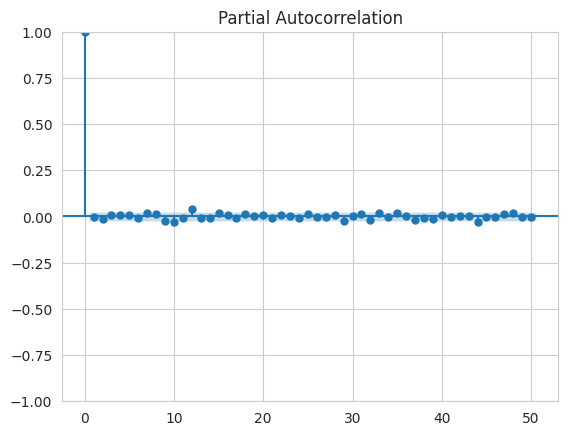

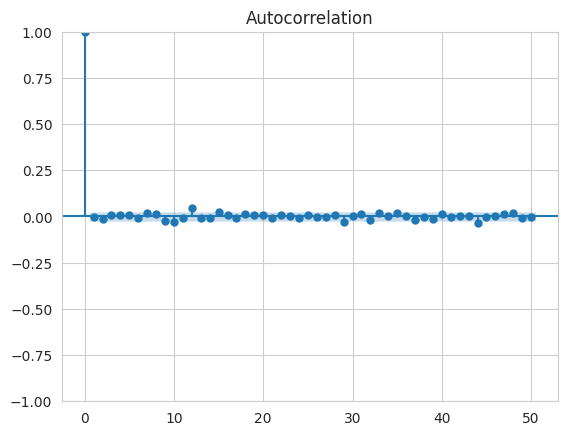

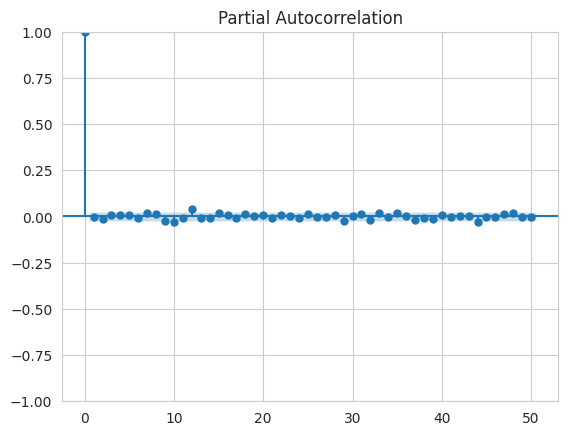

In [ ]:
plot_acf(df_log['First_Diff'], lags=50)
plot_pacf(df_log['First_Diff'], lags=50, method='ywm')

Try and error to find best ARIMA model

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

warnings.filterwarnings("ignore")

series = df_usd['[US dollar ]']
results = []

for p in range(0, 4):
    for d in range(0, 3):
        for q in range(0, 4):
            try:
                model = ARIMA(series, order=(p, d, q)).fit()
                fitted = model.fittedvalues
                min_len = min(len(series), len(fitted))
                rmse = np.sqrt(mean_squared_error(series.iloc[-min_len:], fitted.iloc[-min_len:]))
                results.append(((p, d, q), model.aic, rmse))
                print(f"ARIMA{(p, d, q)} | AIC: {model.aic:.2f} | RMSE: {rmse:.6f}")
            except:
                continue

results_sorted = sorted(results, key=lambda x: x[1])

print("\n‚úÖ Top 5 Models by AIC:")
for order, aic, rmse in results_sorted[:5]:
    print(f"ARIMA{order} | AIC: {aic:.2f} | RMSE: {rmse:.6f}")

ARIMA(0, 0, 0) | AIC: -5813.74 | RMSE: 0.155650
ARIMA(0, 0, 1) | AIC: -14551.13 | RMSE: 0.080208
ARIMA(0, 0, 2) | AIC: -21594.28 | RMSE: 0.047003
ARIMA(0, 0, 3) | AIC: -26865.77 | RMSE: 0.031508
ARIMA(0, 1, 0) | AIC: -46632.92 | RMSE: 0.016135
ARIMA(0, 1, 1) | AIC: -46631.11 | RMSE: 0.016135
ARIMA(0, 1, 2) | AIC: -46630.04 | RMSE: 0.016135
ARIMA(0, 1, 3) | AIC: -46628.51 | RMSE: 0.016135
ARIMA(0, 2, 0) | AIC: -42021.74 | RMSE: 0.019055
ARIMA(0, 2, 1) | AIC: -46608.74 | RMSE: 0.017696
ARIMA(0, 2, 2) | AIC: -46606.98 | RMSE: 0.017696
ARIMA(0, 2, 3) | AIC: -46604.56 | RMSE: 0.017696
ARIMA(1, 0, 0) | AIC: -46634.06 | RMSE: 0.007038
ARIMA(1, 0, 1) | AIC: -46632.21 | RMSE: 0.007038
ARIMA(1, 0, 2) | AIC: -46631.07 | RMSE: 0.007037
ARIMA(1, 0, 3) | AIC: -46629.61 | RMSE: 0.007037
ARIMA(1, 1, 0) | AIC: -46631.11 | RMSE: 0.016135
ARIMA(1, 1, 1) | AIC: -46628.91 | RMSE: 0.016135
ARIMA(1, 1, 2) | AIC: -46629.73 | RMSE: 0.016135
ARIMA(1, 1, 3) | AIC: -46624.65 | RMSE: 0.016135
ARIMA(1, 2, 0) | AIC: